In [2]:
import pickle

with open('data_extract/ontology.pickle', 'rb') as f:
    ontology = pickle.load(f)

## grand parent taxon

In [15]:
ontology_d = {}
for d in ontology:
    ontology_d[d["id"]]=d

In [17]:
for d in ontology:
    try:
        d["grand_parent_taxon"] = ontology_d[d["id"]]["parent_taxon"]
    except:
        pass

In [12]:
len(ontology)

50646

In [236]:
# ・距離行列間の距離を出す方法について
# ・引き算

# ・距離行列からグラフを構成＝＞グラフの基本統計量を出す？？
# ・ノードの種類がそろっていることを利用
# ・AにあってBにあるエッジの件数をX（A,B）に書いたような行列
# ・知識グラフにあるエッジはBERTにもある　当の考察が理想（実際はどうなるか謎）

In [237]:
# result_mean_vec[0:3]

In [74]:
# result_mean_vec[0]

In [71]:
description = []
for d in result_mean_vec:
    if d["type"]=="br":
        description.append(d["description"])

In [238]:
# description

## BERT embedding

In [29]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertJapaneseTokenizer

model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_jp = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
tokenizer_jp = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# GPU を利用する，GPUがなかった人はこのステップをスキップして
# device = torch.device("cuda:0")
# model = model.to(device)
# model_jp = model_jp.to(device)

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [30]:
def get_word_embedding(text:str):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(device)

    outputs = model(input_ids)
    last_hidden_states = outputs[1]
    last_hidden_states = last_hidden_states.to(device)
    # The last hidden-state is the first element of the output tuple
    return last_hidden_states[0].detach().to(device)

In [31]:
def get_word_embedding_jp(text:str):
    input_ids = torch.tensor(tokenizer_jp.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(device)

    outputs = model_jp(input_ids)
    last_hidden_states = outputs[1]
    last_hidden_states = last_hidden_states.to(device)
    # The last hidden-state is the first element of the output tuple
    return last_hidden_states[0].detach().to(device)

##### ・with_soundにBERTの埋め込み項目を付与

In [193]:
for d in with_sound:
    d["en_embedding"] = get_word_embedding(d["en_name"])

In [204]:
for d in with_sound:
    d["jp_embedding"] = get_word_embedding_jp(d["ja_name"])

In [164]:
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [169]:
col = [d["id"]+" :"+d["en_name"]+"/"+d["ja_name"] for d in with_sound]

In [176]:
import pandas as pd
data = pd.DataFrame(index=range(len(col)), columns=col)
data_jp = pd.DataFrame(index=range(len(col)), columns=col)

In [175]:
col[0:2]

['Q208335 :Red Phalarope/ハイイロヒレアシシギ', 'Q206630 :Ortolan Bunting/ズアオホオジロ']

In [179]:
for i in range(len(with_sound)):
    d1 = with_sound[i]
    for j in range(len(with_sound)):
        d2 = with_sound[j]
        c_s = cos_sim(d1["en_embedding"].cpu(),d2["en_embedding"].cpu())
        data.iat[i,j] = c_s
        data.iat[j,i] = c_s

In [205]:
for i in range(len(with_sound)):
    d1 = with_sound[i]
    for j in range(len(with_sound)):
        d2 = with_sound[j]
        c_s = cos_sim(d1["jp_embedding"].cpu(),d2["jp_embedding"].cpu())
        data_jp.iat[i,j] = c_s
        data_jp.iat[j,i] = c_s

In [161]:
ans

0.9629768

In [211]:
len(data)

426

In [180]:
data

Q208335 :Red Phalarope/ハイイロヒレアシシギ Q206630 :Ortolan Bunting/ズアオホオジロ  \
0                                 1.0                         0.962977   
1                            0.962977                              1.0   
2                            0.970527                         0.942481   
3                            0.970958                         0.980576   
4                            0.939121                         0.884881   
..                                ...                              ...   
421                          0.981135                         0.946409   
422                          0.951352                         0.973818   
423                          0.976936                         0.941618   
424                          0.877047                         0.830863   
425                          0.819316                         0.765554   

    Q266107 :Forest Wagtail/イワミセキレイ Q200339 :Mandarin Duck/オシドリ  \
0                          0.970527                    0.970958   
1                          0.942481                    0.980576   
2                               1.0                    0.961788   
3                          0.961788                         1.0   
4                          0.886967                    0.905723   
..                              ...                         ...   
421                        0.974628                    0.961931   
422                        0.959936                    0.958321   
423                        0.973656                    0.967018   
424                        0.797071                    0.847609   
425                        0.725607                    0.783313   

    Q18851 :Little Ringed Plover/コチドリ Q54696 :Eurasian Collared Dove/シラコバト  \
0                            0.939121                             0.955572   
1                            0.884881                             0.893274   
2                            0.886967                             0.967021   
3                            0.905723                             0.924458   
4                                 1.0                             0.917026   
..                                ...                                  ...   
421                           0.92304                             0.967825   
422                          0.831264                             0.902489   
423                          0.942269                              0.97448   
424                          0.962551                             0.841017   
425                          0.929634                             0.791202   

    Q507383 :House Crow/イエガラス Q174088 :Hawfinch/シメ  \
0                    0.883984             0.956918   
1                    0.925956             0.983079   
2                    0.920447             0.928283   
3                    0.905016             0.983733   
4                    0.725408             0.908252   
..                        ...                  ...   
421                  0.895823             0.941271   
422                  0.976038             0.946046   
423                  0.866463             0.947804   
424                  0.622349             0.863912   
425                  0.543275             0.809291   

    Q25334 :European Robin/ヨーロッパコマドリ Q12265905 :Kamchatka leaf warbler/オオムシクイ  \
0                           0.887208                                 0.841714   
1                           0.923622                                 0.820877   
2                            0.90783                                 0.746585   
3                           0.893703                                 0.828532   
4                           0.749586                                 0.931049   
..                               ...                                      ...   
421                         0.876387                                  0.81688   
422                         0.963353                                 0.71932

In [213]:
!pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 41.9 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ------------------------------------- 965.4/965.4 kB 20.3 MB/s eta 0:00:00
     -------------------------------------- 161.3/161.3 kB 9.4 MB/s eta 0:00:00


In [214]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [222]:
x = data.values.astype(dtype=float)

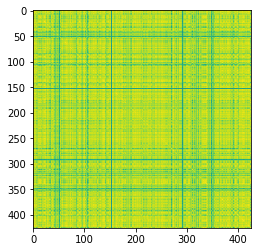

In [223]:
plt.imshow(x)

In [224]:
y = data_jp.values.astype(dtype=float)

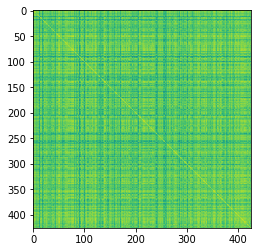

In [225]:
plt.imshow(y)

In [ ]:
#クラスタリングをしないと意味がない
# 生データを見続ける　sum等の要約をしない

In [226]:
!pip install seaborn


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 288.2/288.2 kB 5.9 MB/s eta 0:00:00


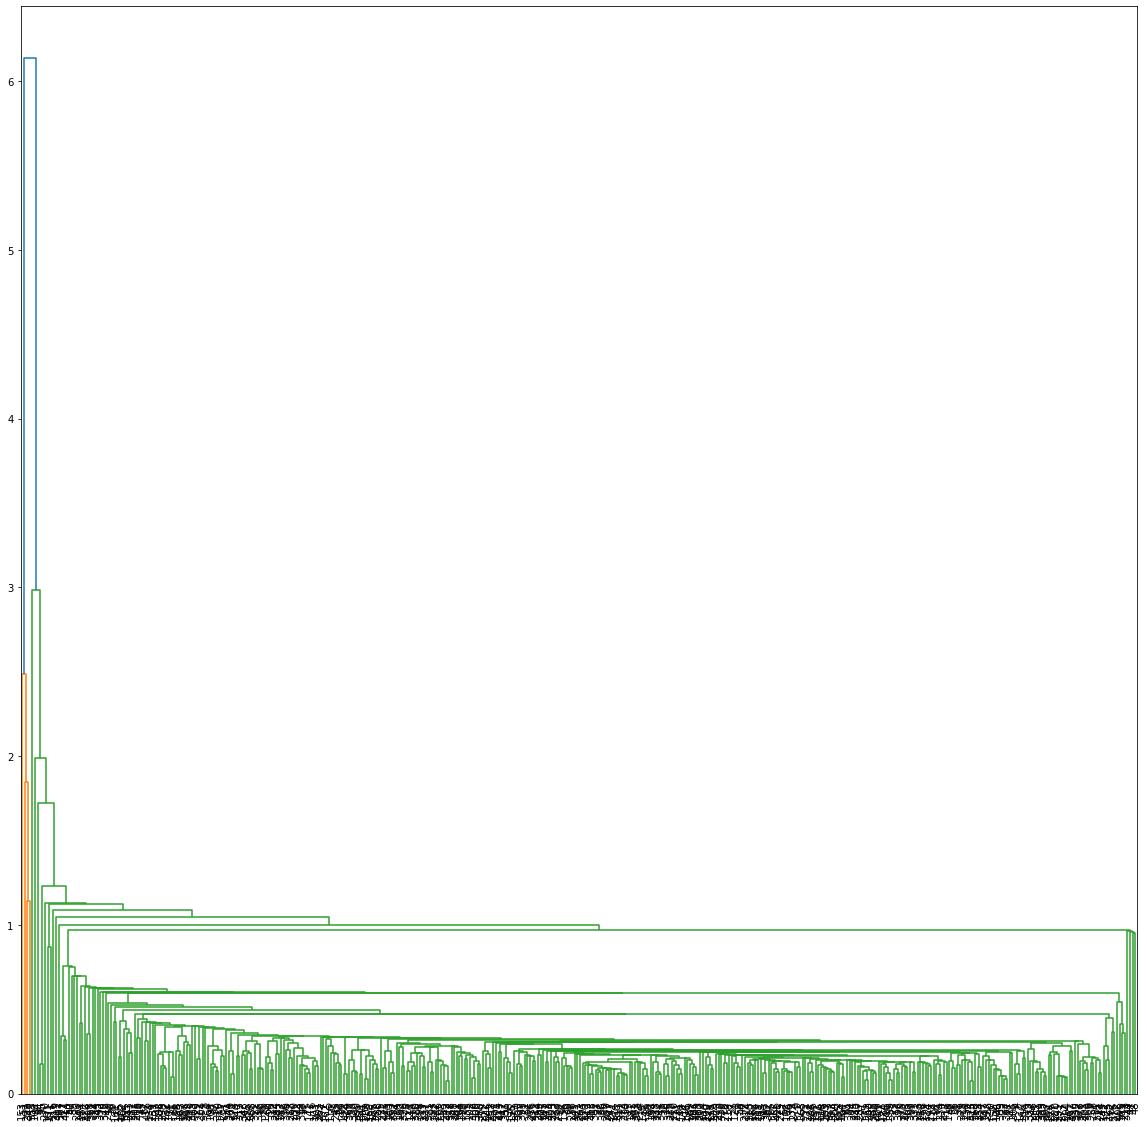

In [229]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
plt.figure(figsize=(20,20))
z = linkage(x, method='single', metric='euclid')
# dendrogram(z,labels=codelist)
dendrogram(z)
plt.tick_params(labelsize=10)

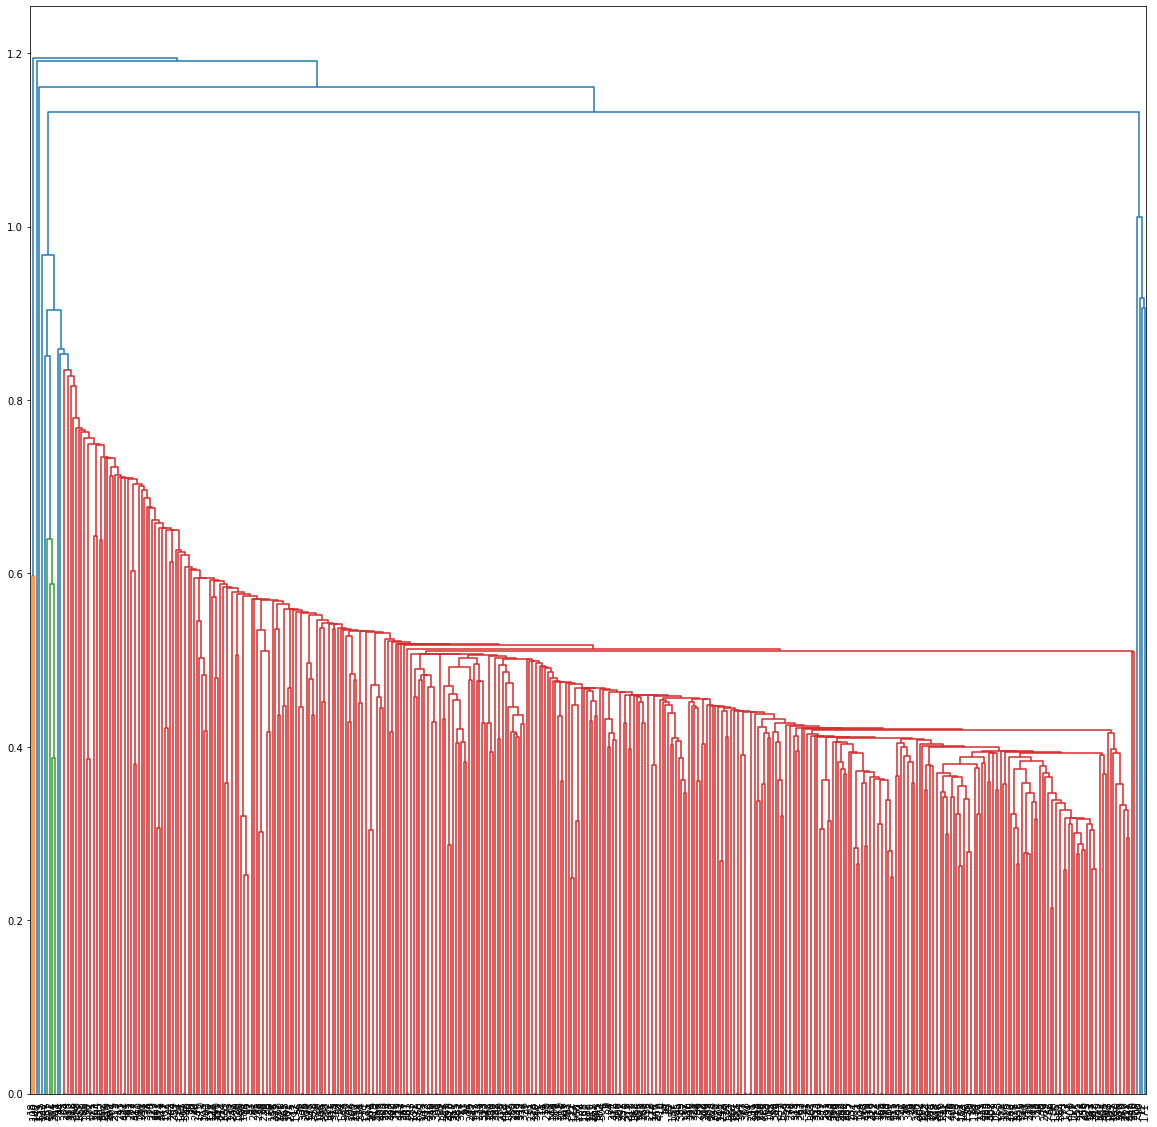

In [239]:
plt.figure(figsize=(20,20))
z = linkage(y, method='single', metric='euclid')
# dendrogram(z,labels=codelist)
dendrogram(z)
plt.tick_params(labelsize=10)

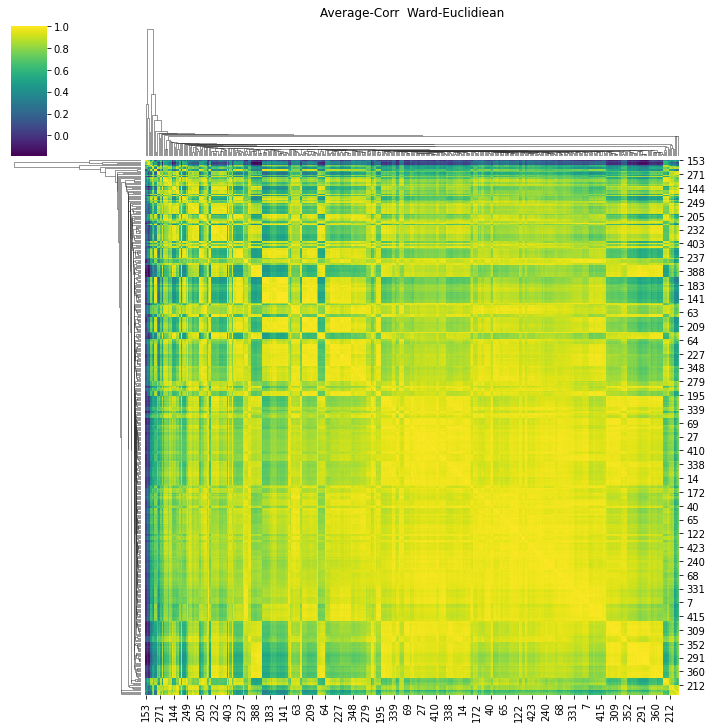

In [230]:
g = sns.clustermap(x, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')
g.savefig('average-corr__ward-euclidean.png', dpi=150)
# 右端、左端を解釈

Text(0.5, 1.0, 'Average-Corr  Ward-Euclidiean')

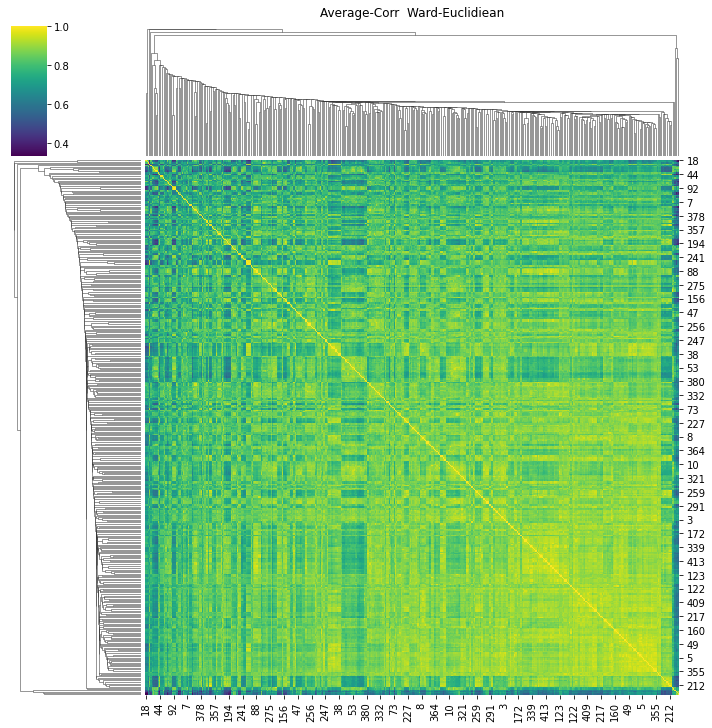

In [276]:
g = sns.clustermap(y, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')
# g.savefig('average-corr__ward-euclidean.png', dpi=150)

In [206]:
data_jp

Q208335 :Red Phalarope/ハイイロヒレアシシギ Q206630 :Ortolan Bunting/ズアオホオジロ  \
0                                 1.0                         0.901366   
1                            0.901366                              1.0   
2                            0.787955                         0.867586   
3                            0.722292                          0.87485   
4                            0.707367                         0.825391   
..                                ...                              ...   
421                          0.829193                         0.912491   
422                          0.828683                         0.902806   
423                          0.896876                         0.922234   
424                          0.637214                         0.723706   
425                          0.809673                         0.892128   

    Q266107 :Forest Wagtail/イワミセキレイ Q200339 :Mandarin Duck/オシドリ  \
0                          0.787955                    0.722292   
1                          0.867586                     0.87485   
2                               1.0                    0.893396   
3                          0.893396                         1.0   
4                          0.841161                    0.914387   
..                              ...                         ...   
421                        0.902173                    0.928221   
422                        0.873242                    0.861017   
423                        0.860865                    0.831993   
424                        0.737673                    0.800243   
425                        0.952109                    0.925761   

    Q18851 :Little Ringed Plover/コチドリ Q54696 :Eurasian Collared Dove/シラコバト  \
0                            0.707367                             0.789267   
1                            0.825391                             0.868757   
2                            0.841161                             0.945664   
3                            0.914387                             0.901642   
4                                 1.0                             0.838762   
..                                ...                                  ...   
421                          0.845265                             0.941795   
422                          0.819918                              0.86153   
423                          0.828754                             0.843426   
424                          0.800093                             0.797849   
425                          0.851292                             0.962249   

    Q507383 :House Crow/イエガラス Q174088 :Hawfinch/シメ  \
0                    0.836676              0.62789   
1                    0.869891             0.768214   
2                    0.926627             0.778388   
3                    0.837618             0.854081   
4                     0.76318             0.875166   
..                        ...                  ...   
421                  0.902777             0.768807   
422                  0.856572             0.840531   
423                  0.840907             0.759782   
424                  0.719746             0.763117   
425                  0.925527             0.784679   

    Q25334 :European Robin/ヨーロッパコマドリ Q12265905 :Kamchatka leaf warbler/オオムシクイ  \
0                           0.810168                                 0.751058   
1                           0.881421                                 0.853459   
2                           0.918473                                  0.88648   
3                           0.907618                                 0.910293   
4                           0.810201                                 0.870435   
..                               ...                                      ...   
421                         0.944897                                 0.916698   
422                         0.852458                                 0.81626

In [207]:
data.to_csv('data_matrix/bert_en.csv')
data_jp.to_csv('data_matrix/bert_jp.csv')

## result_mean_vec

In [69]:
import json
with open('data_external/result_mean_vec.json', newline='',encoding="utf-8") as f:
    result_mean_vec = json.load(f)

#### 音声ベクトルデータ description項目をカタカナに統一

In [74]:
import unittest
from Romaji import Romaji

for d in result_mean_vec:#result_mean_vecのdにd["description_kana"]項目を追加
    try:
        dv_name = d["description"].split(" ")[1]
    except:
        dv_name = d["description"]
        dv_name = Romaji.getKana(dv_name)
    d["description_kana"] = dv_name

In [75]:
import pickle
with open('data_extract/ontology.pickle', 'rb') as f:
    ontology = pickle.load(f)

mean_vec_has_id = []

for d_v in result_mean_vec:
    for d_w in ontology:
        if d_w["ja_name"]==d_v["description_kana"]:
            
            d_w["col"] = d_w["id"]+" :"+d_w["en_name"]+"/"+d_w["ja_name"]
            d_w["description"] = d_v["description"]
            d_w["description_kana"] = d_v["description_kana"]
            d_w["sound_vec"] = d_v["vector"]
            mean_vec_has_id.append(d_w)
            
# for d_w in all_BirdDBnode:
#     d_w["col"] = d_w["id"]+" :"+d_w["en_name"]+"/"+d_w["ja_name"]
#     for d_v in result_mean_vec:
#         if d_w["ja_name"]==d_v["description_kana"]:
#             d_w["description"] = d_v["description"]
#             d_w["sound_vec"] = d_v["vector"]
#             d_w["description_kana"] = d_v["description_kana"]
#             mean_vec_has_id.append(d_w)

In [13]:
# mean_vec_has_id[0]

# {'id': 'Q208335',
#  'en_name': 'Red Phalarope',
#  'ja_name': 'ハイイロヒレアシシギ',
#  'en_aliases': "{'0': 'Red Phalarope', '1': 'Grey Phalarope'}",
#  'ja_aliases': '{}',
#  'img_urls': "{'0': 'https://www.wikidata.org/wiki/Q208335#/media/File:Phalaropus%20fulicarius%2010.jpg', '1': 'https://www.wikidata.org/wiki/Q208335#/media/File:Grey%20Phalarope.jpg'}",
#  'taxon_rank': 'Q7432',
#  'taxon_name': 'Phalaropus fulicarius',
#  'parent_taxon': 'Q253776',
#  'BirdJPBookDB__data_audio_id': '2_72',
#  'BirdJPBookDB__data_birdname': 'ハイイロヒレアシシギ',
#  'BirdResearchDB_label01_32k_audio_id': '',
#  'BirdResearchDB_label01_32k_birdname': '',
#  'JP': '1',
#  'Research': '0',
#  'col': 'Q208335 :Red Phalarope/ハイイロヒレアシシギ',
#  'description': '72 ハイイロヒレアシシギ',
#  'sound_vec': [-0.34293076395988464,
#   0.8081668019294739,....]}

In [78]:
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [79]:
col = [d["col"] for d in mean_vec_has_id]

In [80]:
import pandas as pd
data_sound = pd.DataFrame(index=range(len(col)), columns=col)

In [81]:
for i in range(len(mean_vec_has_id)):
    d1 = mean_vec_has_id[i]
    for j in range(len(mean_vec_has_id)):
        d2 = mean_vec_has_id[j]
        c_s = cos_sim(d1["sound_vec"],d2["sound_vec"])
        data_sound.iat[i,j] = c_s
        data_sound.iat[j,i] = c_s

In [82]:
data_sound

Q18859 :Common Redshank/アカアシシギ Q26209 :Great Spotted Woodpecker/アカゲラ  \
0                              1.0                              0.992876   
1                         0.992876                                   1.0   
2                         0.987931                               0.99832   
3                         0.983005                              0.996458   
4                         0.993334                              0.998711   
..                             ...                                   ...   
492                       0.996156                              0.995725   
493                         0.9886                              0.997218   
494                       0.982376                              0.966274   
495                       0.993308                              0.997959   
496                       0.995039                              0.997826   

    Q1589003 :Brown-headed Thrush/アカハラ Q27075672 :Ryukyu Robin/アカヒゲ  \
0                             0.987931                     0.983005   
1                              0.99832                     0.996458   
2                                  1.0                     0.997666   
3                             0.997666                          1.0   
4                             0.998026                     0.996731   
..                                 ...                          ...   
492                           0.992416                     0.991539   
493                           0.997422                     0.998685   
494                           0.954995                     0.954578   
495                           0.996168                     0.996561   
496                           0.995429                      0.99445   

    Q2587219 :Izu Thrush/アカコッコ Q790616 :Brown Shrike/アカモズ  \
0                     0.993334                   0.985363   
1                     0.998711                   0.997498   
2                     0.998026                   0.999185   
3                     0.996731                   0.997587   
4                          1.0                   0.997011   
..                         ...                        ...   
492                   0.997485                   0.990762   
493                   0.998476                   0.997194   
494                   0.967949                   0.949848   
495                   0.998351                   0.994689   
496                   0.997757                   0.994325   

    Q31866 :Fork-tailed Swift/アマツバメ Q997448 :White-bellied Green Pigeon/アオバト  \
0                          0.988951                                 0.977278   
1                          0.996586                                 0.993987   
2                          0.996227                                 0.997147   
3                          0.998105                                 0.998064   
4                          0.998433                                 0.993419   
..                              ...                                      ...   
492                        0.996333                                 0.984992   
493                        0.999533                                 0.995715   
494                        0.965123                                  0.93957   
495                        0.997825                                 0.992463   
496                        0.995977                                 0.990448   

    Q195518 :Japanese Green Woodpecker/アオゲラ Q1190674 :Black-faced Bunting/アオジ  \
0                                  0.997395                          0.987612   
1                                  0.995783                          0.998071   
2                                  0.992209                          0.999644   
3                                  0.990867                          0.997374   
4                                  0.997156                          0.997862   
..                                      ...               

In [22]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [83]:
x = data_sound.values.astype(dtype=float)

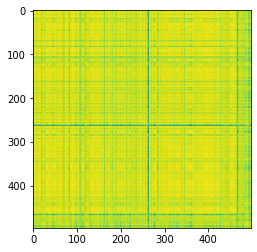

In [84]:
plt.imshow(x)

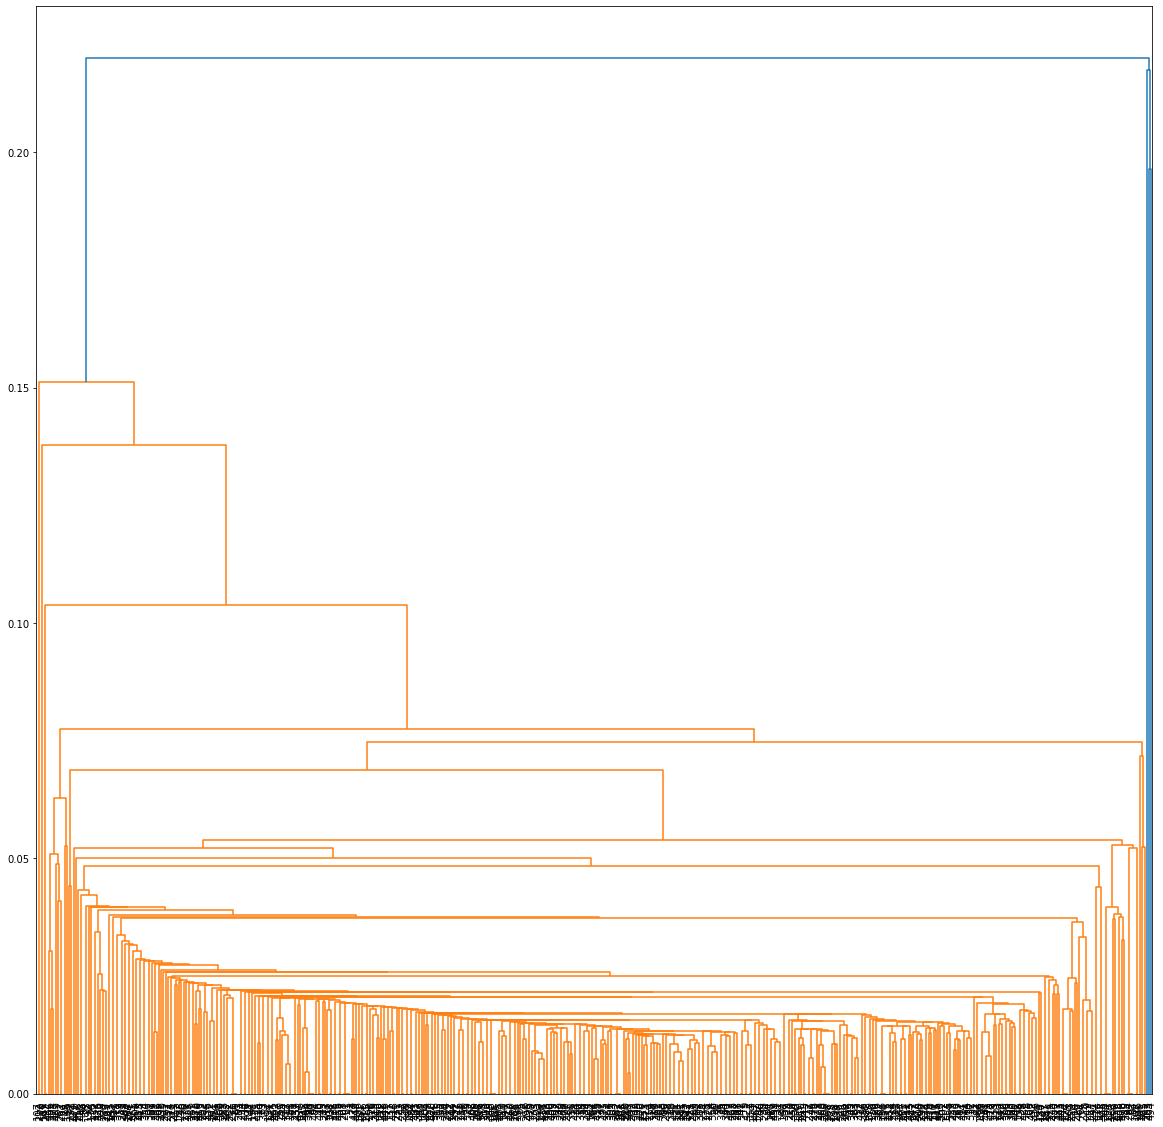

In [88]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
plt.figure(figsize=(20,20))
z = linkage(x, method='single', metric='euclid')
# dendrogram(z,labels=codelist)
dendrogram(z)
plt.tick_params(labelsize=10)

Text(0.5, 1.0, 'Average-Corr  Ward-Euclidiean')

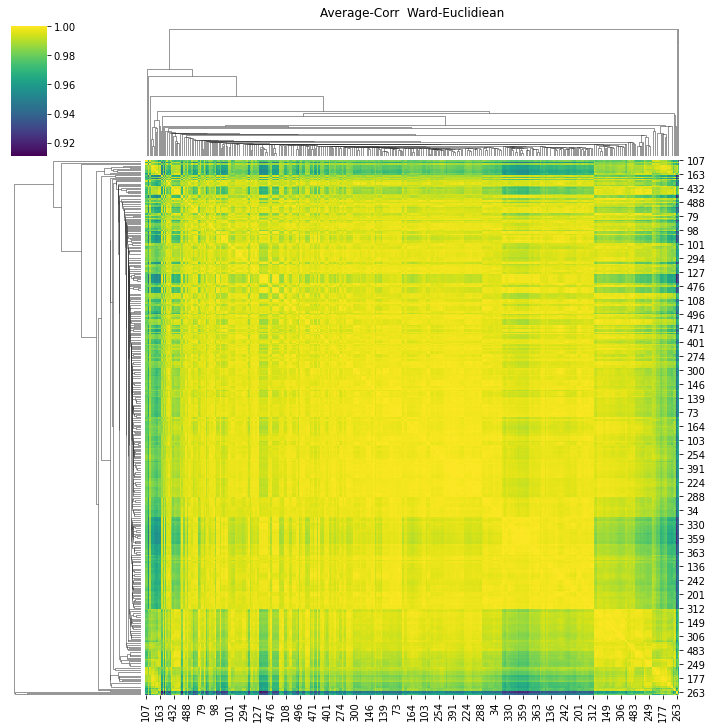

In [89]:
g = sns.clustermap(x, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')
# g.savefig('average-corr__ward-euclidean.png', dpi=150)
# 右端、左端を解釈

In [90]:
data_sound.to_csv('data_matrix/sound.csv')

## soundの列名に合わせてBERTも最作成

In [91]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertJapaneseTokenizer

model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_jp = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
tokenizer_jp = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

In [92]:
# GPU を利用する，GPUがなかった人はこのステップをスキップして
device = torch.device("cpu")
model = model.to(device)
model_jp = model_jp.to(device)

In [93]:
def get_word_embedding(text:str):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(device)

    outputs = model(input_ids)
    last_hidden_states = outputs[1]
    last_hidden_states = last_hidden_states.to(device)
    # The last hidden-state is the first element of the output tuple
    return last_hidden_states[0].detach().to(device)

In [94]:
def get_word_embedding_jp(text:str):
    input_ids = torch.tensor(tokenizer_jp.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(device)

    outputs = model_jp(input_ids)
    last_hidden_states = outputs[1]
    last_hidden_states = last_hidden_states.to(device)
    # The last hidden-state is the first element of the output tuple
    return last_hidden_states[0].detach().to(device)

・with_soundにBERTの埋め込み項目を付与

In [95]:
# mean_vec_has_id[0]

In [96]:
for d in mean_vec_has_id:
    d["en_embedding"] = get_word_embedding(d["en_name"])

In [97]:
for d in mean_vec_has_id:
    d["jp_embedding"] = get_word_embedding_jp(d["ja_name"])

In [98]:
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [99]:
col = [d["id"]+" :"+d["en_name"]+"/"+d["ja_name"] for d in mean_vec_has_id]

import pandas as pd
data = pd.DataFrame(index=range(len(col)), columns=col)
data_jp = pd.DataFrame(index=range(len(col)), columns=col)

In [100]:
for i in range(len(mean_vec_has_id)):
    d1 = mean_vec_has_id[i]
    for j in range(len(mean_vec_has_id)):
        d2 = mean_vec_has_id[j]
        c_s = cos_sim(d1["en_embedding"].cpu(),d2["en_embedding"].cpu())
        data.iat[i,j] = c_s
        data.iat[j,i] = c_s

for i in range(len(mean_vec_has_id)):
    d1 = mean_vec_has_id[i]
    for j in range(len(mean_vec_has_id)):
        d2 = mean_vec_has_id[j]
        c_s = cos_sim(d1["jp_embedding"].cpu(),d2["jp_embedding"].cpu())
        data_jp.iat[i,j] = c_s
        data_jp.iat[j,i] = c_s

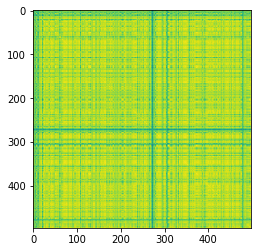

In [107]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

x = data.values.astype(dtype=float)
# x = data_jp.values.astype(dtype=float)
plt.imshow(x)

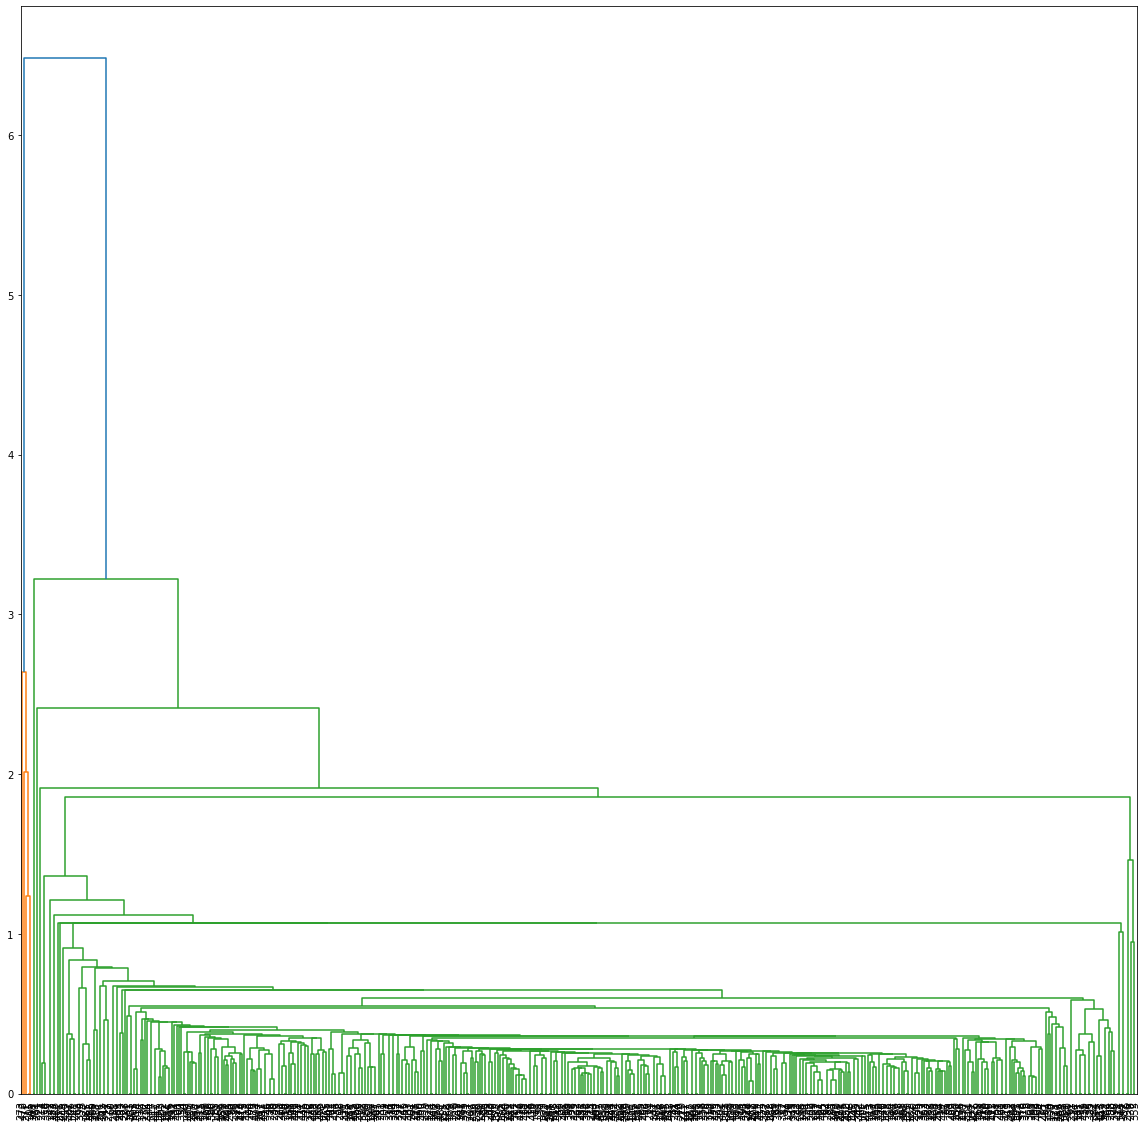

In [108]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns

plt.figure(figsize=(20,20))
z = linkage(x, method='single', metric='euclid')
dendrogram(z)
plt.tick_params(labelsize=10)

Text(0.5, 1.0, 'Average-Corr  Ward-Euclidiean')

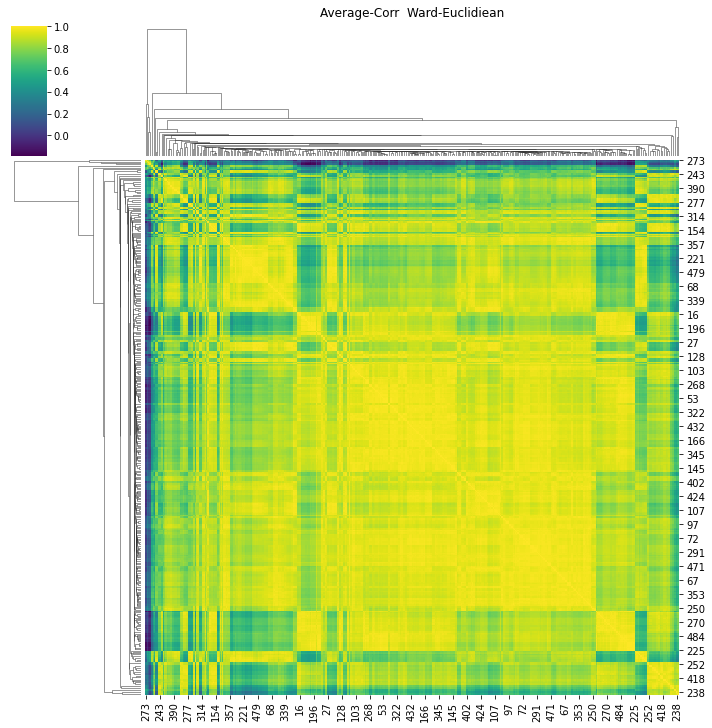

In [109]:
g = sns.clustermap(x, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')

In [104]:
data

Q18859 :Common Redshank/アカアシシギ Q26209 :Great Spotted Woodpecker/アカゲラ  \
0                              1.0                              0.911419   
1                         0.911419                                   1.0   
2                         0.689624                               0.67082   
3                         0.930696                              0.880631   
4                         0.613205                              0.403676   
..                             ...                                   ...   
492                       0.947274                              0.917827   
493                        0.78914                              0.623021   
494                       0.832618                              0.687694   
495                       0.890025                              0.807292   
496                       0.976063                              0.899845   

    Q1589003 :Brown-headed Thrush/アカハラ Q27075672 :Ryukyu Robin/アカヒゲ  \
0                             0.689624                     0.930696   
1                              0.67082                     0.880631   
2                                  1.0                     0.513889   
3                             0.513889                          1.0   
4                             0.167635                     0.711022   
..                                 ...                          ...   
492                            0.56047                     0.987973   
493                           0.316943                      0.87834   
494                           0.384387                     0.912908   
495                           0.440569                     0.973642   
496                           0.610315                     0.963312   

    Q2587219 :Izu Thrush/アカコッコ Q790616 :Brown Shrike/アカモズ  \
0                     0.613205                   0.814106   
1                     0.403676                   0.567361   
2                     0.167635                   0.562232   
3                     0.711022                   0.735365   
4                          1.0                   0.814548   
..                         ...                        ...   
492                   0.664098                   0.730337   
493                   0.944889                   0.852713   
494                   0.911165                   0.850205   
495                   0.816347                   0.783052   
496                   0.683345                   0.815358   

    Q31866 :Fork-tailed Swift/アマツバメ Q997448 :White-bellied Green Pigeon/アオバト  \
0                          0.690164                                 0.832842   
1                          0.583066                                 0.858912   
2                          0.933997                                 0.915593   
3                          0.509847                                 0.693678   
4                          0.306815                                 0.262203   
..                              ...                                      ...   
492                        0.545093                                 0.742148   
493                        0.410473                                  0.44974   
494                        0.449071                                 0.516045   
495                        0.461862                                 0.608384   
496                        0.630307                                 0.779617   

    Q195518 :Japanese Green Woodpecker/アオゲラ Q1190674 :Black-faced Bunting/アオジ  \
0                                  0.888223                          0.930101   
1                                  0.991638                           0.97281   
2                                  0.605815                          0.670894   
3                                  0.885373                          0.924215   
4                                  0.406718                          0.504437   
..                                      ...               

In [105]:
data_jp

Q18859 :Common Redshank/アカアシシギ Q26209 :Great Spotted Woodpecker/アカゲラ  \
0                              1.0                              0.860488   
1                         0.860488                                   1.0   
2                         0.810471                              0.920296   
3                         0.886495                              0.906836   
4                         0.904132                              0.868435   
..                             ...                                   ...   
492                       0.871481                              0.894702   
493                       0.881327                              0.921478   
494                       0.851952                              0.877977   
495                       0.911078                               0.88167   
496                       0.854709                              0.871146   

    Q1589003 :Brown-headed Thrush/アカハラ Q27075672 :Ryukyu Robin/アカヒゲ  \
0                             0.810471                     0.886495   
1                             0.920296                     0.906836   
2                                  1.0                     0.906607   
3                             0.906607                          1.0   
4                             0.819821                     0.908714   
..                                 ...                          ...   
492                           0.812724                     0.839856   
493                            0.86175                     0.898218   
494                           0.861525                       0.8939   
495                           0.825146                     0.894659   
496                           0.863926                     0.898823   

    Q2587219 :Izu Thrush/アカコッコ Q790616 :Brown Shrike/アカモズ  \
0                     0.904132                   0.860254   
1                     0.868435                   0.916815   
2                     0.819821                    0.89686   
3                     0.908714                   0.885215   
4                          1.0                   0.883469   
..                         ...                        ...   
492                   0.843669                    0.84716   
493                   0.881349                   0.861057   
494                   0.811039                   0.812245   
495                   0.858582                    0.80222   
496                   0.779814                   0.800577   

    Q31866 :Fork-tailed Swift/アマツバメ Q997448 :White-bellied Green Pigeon/アオバト  \
0                          0.907652                                 0.804749   
1                           0.87432                                 0.790332   
2                          0.860474                                 0.769608   
3                          0.863335                                 0.848152   
4                          0.862425                                 0.748162   
..                              ...                                      ...   
492                        0.869761                                 0.733384   
493                        0.866812                                 0.834793   
494                        0.827363                                 0.873434   
495                          0.8397                                 0.890001   
496                        0.861566                                  0.91046   

    Q195518 :Japanese Green Woodpecker/アオゲラ Q1190674 :Black-faced Bunting/アオジ  \
0                                  0.885363                          0.697957   
1                                  0.952358                           0.70124   
2                                  0.908396                          0.746567   
3                                  0.924419                           0.79407   
4                                  0.870316                          0.664979   
..                                      ...               

In [106]:
data.to_csv('data_matrix/bert_en.csv')
data_jp.to_csv('data_matrix/bert_jp.csv')

## グラフを利用したマトリックス

In [110]:
import pickle

with open('data_extract/ontology.pickle', 'rb') as f:
    ontology = pickle.load(f)

In [111]:
import networkx as nx
G = nx.Graph()

for d in ontology:
    G.add_node(d["id"])
    if d["parent_taxon"] != None:
        G.add_node(d["parent_taxon"])
        G.add_edge(d["id"],d["parent_taxon"])

In [112]:
col = [d["id"]+" :"+d["en_name"]+"/"+d["ja_name"] for d in mean_vec_has_id]

import pandas as pd
data_graph = pd.DataFrame(index=range(len(col)), columns=col)

In [113]:
error_ij = []
print(len(mean_vec_has_id))
for i in range(len(mean_vec_has_id)):
    d1 = mean_vec_has_id[i]
    for j in range(len(mean_vec_has_id)):
        d2 = mean_vec_has_id[j]
        print('\r%d / %d' %(j, i), end='')
        try:
            shortest_path = len(nx.shortest_path(G, source=d1["id"], target=d2["id"]))
        except:
            try:
                shortest_path = len(nx.shortest_path(G, source=d1["id"], target="Q5113"))+len(nx.shortest_path(G, source=d2["id"], target="Q5113"))
            except:
                shortest_path = None
                error_ij.append([i,j])
        
        data_graph.iat[i,j] = shortest_path
        data_graph.iat[j,i] = shortest_path

497
496 / 496

In [117]:
data_graph

Q18859 :Common Redshank/アカアシシギ Q26209 :Great Spotted Woodpecker/アカゲラ  \
0                                1                                    14   
1                               14                                     1   
2                               20                                    19   
3                               21                                    20   
4                               20                                    19   
..                             ...                                   ...   
492                             17                                    16   
493                             17                                    16   
494                             17                                    16   
495                             17                                    16   
496                             20                                    19   

    Q1589003 :Brown-headed Thrush/アカハラ Q27075672 :Ryukyu Robin/アカヒゲ  \
0                                   20                           21   
1                                   19                           20   
2                                    1                            8   
3                                    8                            1   
4                                    3                            8   
..                                 ...                          ...   
492                                 10                           11   
493                                 10                           11   
494                                 10                           11   
495                                 10                           11   
496                                 11                           12   

    Q2587219 :Izu Thrush/アカコッコ Q790616 :Brown Shrike/アカモズ  \
0                           20                         17   
1                           19                         16   
2                            3                         10   
3                            8                         11   
4                            1                         10   
..                         ...                        ...   
492                         10                          7   
493                         10                          7   
494                         10                          7   
495                         10                          7   
496                         11                         10   

    Q31866 :Fork-tailed Swift/アマツバメ Q997448 :White-bellied Green Pigeon/アオバト  \
0                                13                                       14   
1                                12                                       13   
2                                18                                       19   
3                                19                                       20   
4                                18                                       19   
..                              ...                                      ...   
492                              15                                       16   
493                              15                                       16   
494                              15                                       16   
495                              15                                       16   
496                              18                                       19   

    Q195518 :Japanese Green Woodpecker/アオゲラ Q1190674 :Black-faced Bunting/アオジ  \
0                                        14                                17   
1                                         5                                16   
2                                        19                                10   
3                                        20                                11   
4                                        19                                10   
..                                      ...               

Text(0.5, 1.0, 'Average-Corr  Ward-Euclidiean')

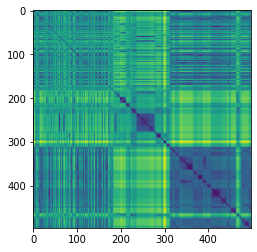

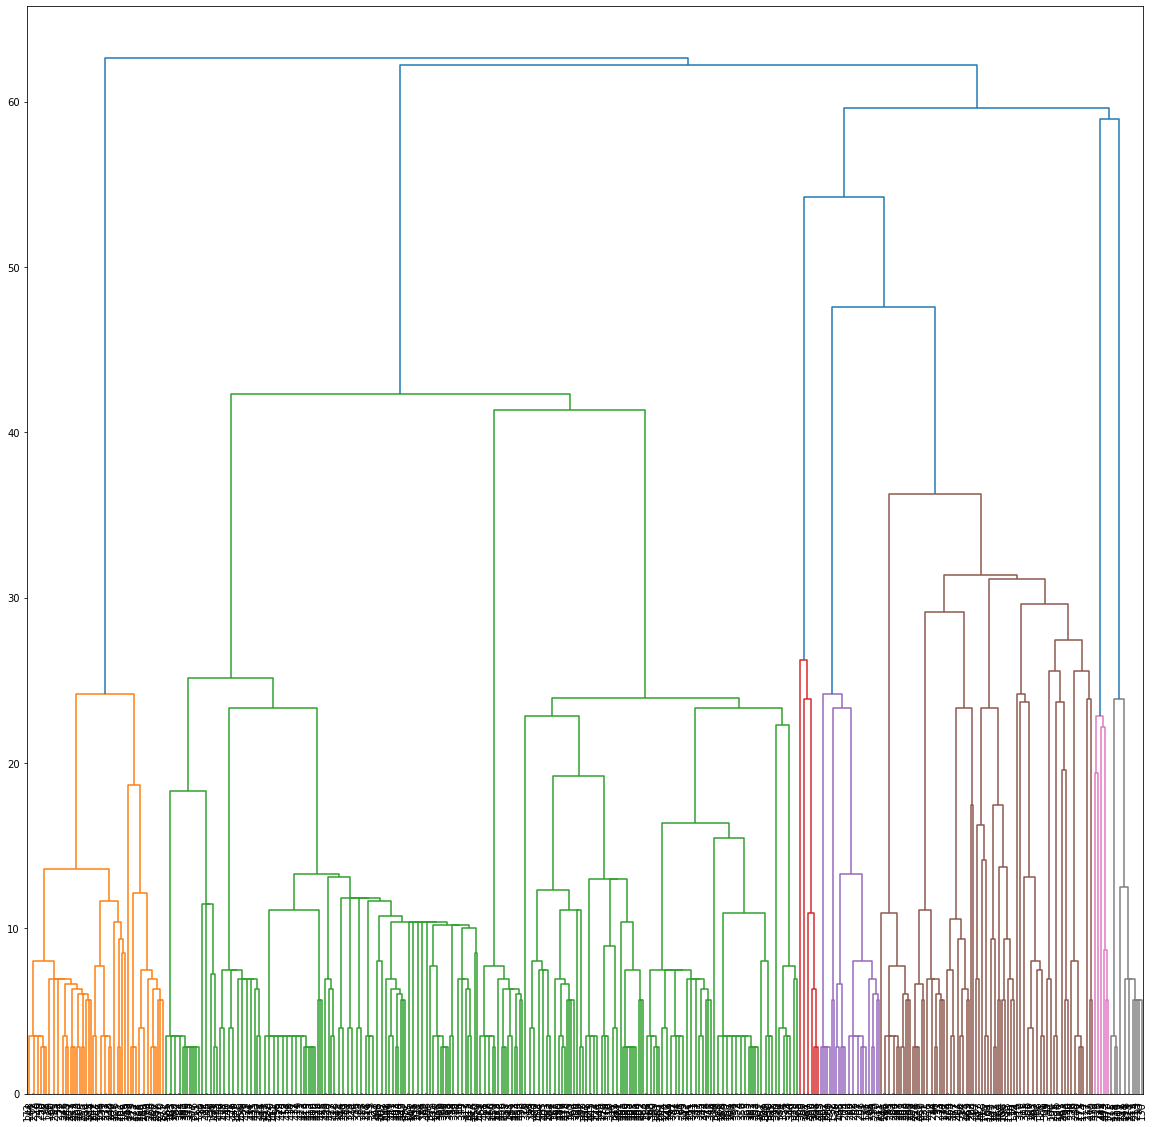

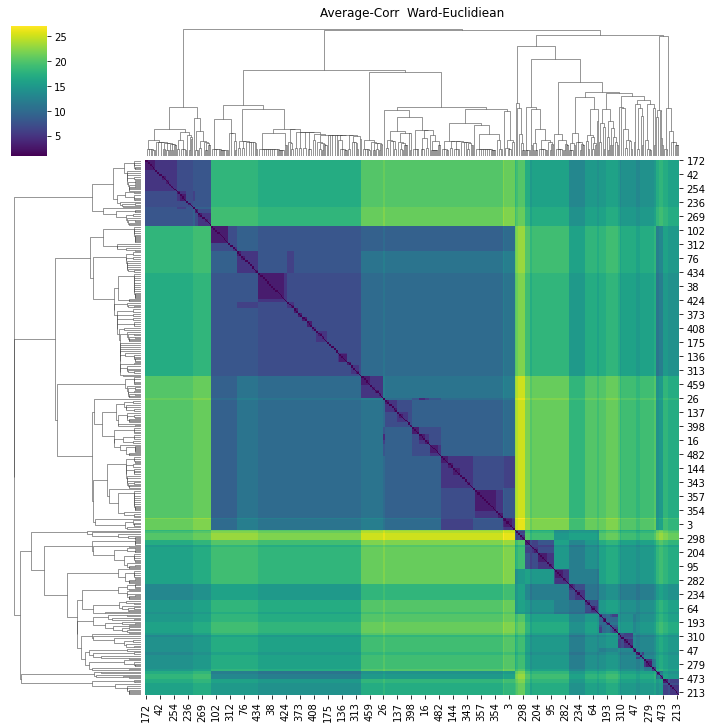

In [118]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# x = data.values.astype(dtype=float)
x = data_graph.values.astype(dtype=float)
plt.imshow(x)

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns

plt.figure(figsize=(20,20))
z = linkage(x, method='single', metric='euclid')
dendrogram(z)
plt.tick_params(labelsize=10)

g = sns.clustermap(x, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')

In [123]:
data_graph.to_csv('data_matrix/graph.csv')

## ノーマライズおよびフローベニウスノルム（要素ごとの差の二乗和）の計算

In [1]:
import pandas as pd

In [2]:
data_jp = pd.read_csv('data_matrix/bert_jp.csv',index_col=0)
data_en = pd.read_csv('data_matrix/bert_en.csv',index_col=0)
data_sound = pd.read_csv('data_matrix/sound.csv',index_col=0)
data_graph = pd.read_csv('data_matrix/graph.csv',index_col=0)

In [3]:
def Norm(df):
    return (df - df.values.min()) / (df.values.max() - df.values.min())
#データの形を見てから決める　正規分布に近いかどうか

In [4]:
def Norm4graph(df):
    return (1-(df - df.values.min()) / (df.values.max() - df.values.min()))
#データの形を見てから決める　正規分布に近いかどうか

In [5]:
data_jp_norm = Norm(data_jp)
data_en_norm = Norm(data_en)
data_sound_norm = Norm(data_sound)
data_graph_norm = Norm(data_graph)

In [6]:
data_jp_norm.to_csv('data_matrix/bert_jp_norm.csv')
data_en_norm.to_csv('data_matrix/bert_en_norm.csv')
data_sound_norm.to_csv('data_matrix/sound_norm.csv')
data_graph_norm.to_csv('data_matrix/graph_norm.csv')

In [7]:
def Frobenius_Norm(df1,df2):
    dif_df = df1 - df2
    df_2 = dif_df * dif_df
    return df_2.sum().sum()

In [8]:
jp_en_Fro_N = Frobenius_Norm(data_jp_norm,data_en_norm)

In [9]:
jp_en_Fro_N

12565.84560164259

In [10]:
jp_en_Fro_N = Frobenius_Norm(data_jp_norm,data_en_norm)
jp_sound_Fro_N = Frobenius_Norm(data_jp_norm,data_sound_norm)
jp_graph_Fro_N = Frobenius_Norm(data_jp_norm,data_graph_norm)

en_sound_Fro_N = Frobenius_Norm(data_en_norm,data_sound_norm)
en_graph_Fro_N = Frobenius_Norm(data_en_norm,data_graph_norm)

sound_graph_Fro_N = Frobenius_Norm(data_sound_norm,data_graph_norm)

In [11]:
print(jp_en_Fro_N)
print(jp_sound_Fro_N)
print(jp_graph_Fro_N)

print(en_sound_Fro_N)
print(en_graph_Fro_N)

print(sound_graph_Fro_N)

12565.84560164259
14378.264838986523
22528.75740501301
7602.577556944228
41558.0857890608
49258.396051339056


In [12]:
#対応表を作成する
#データプロットののち他のNormarizeを検討（正規分布に近ければ標準正規分布等）
#まずはヒストグラムにより分布を把握＝＞次週までに

#平均，分散，箱ひげ等の基礎分析は論文掲載時
#要素ごとの差が大きいところ，極端な部分のみ観察（考察時の一手法としてはありか）

In [13]:
# まずヒストグラムから閾値を明らかにする
# 隣接行列からグラフを再度構築　＝＞　グラフの類似度を測定　エッジ有無にまで単純化が可能
# グラフ類似度の測定方法は一つではないが　ベン図は確定

In [14]:
# 英語採用が濃厚（情報量が多いのでは？）
# ベン図が描ける　英語ー音声間で距離が近い物（グラフであればどれだけ共通のエッジを持っているか）
# ABC共通の箇所には3種類のグラフに共通するエッジが含まれる 

## ヒストグラムの作成

In [45]:
import pandas as pd
#data_jp = pd.read_csv('data_matrix/bert_jp.csv',index_col=0)
data_en = pd.read_csv('data_matrix/bert_en.csv',index_col=0)
data_sound = pd.read_csv('data_matrix/sound.csv',index_col=0)
data_graph = pd.read_csv('data_matrix/graph.csv',index_col=0)

In [46]:
def Norm(df):
    return (df - df.values.min()) / (df.values.max() - df.values.min())
#データの形を見てから決める　正規分布に近いかどうか

In [47]:
def Norm4graph(df):
    return (1-(df - df.values.min()) / (df.values.max() - df.values.min()))
#データの形を見てから決める　正規分布に近いかどうか

In [48]:
#data_jp_norm = Norm(data_jp)
data_en_norm = Norm(data_en)
data_sound_norm = Norm(data_sound)
data_graph_norm = Norm4graph(data_graph)

In [49]:
data_en_norm

Q18859 :Common Redshank/アカアシシギ  Q26209 :Great Spotted Woodpecker/アカゲラ  \
0                          1.000000                               0.925158   
1                          0.925158                               1.000000   
2                          0.737762                               0.721875   
3                          0.941445                               0.899145   
4                          0.673196                               0.496164   
..                              ...                                    ...   
492                        0.955452                               0.930572   
493                        0.821844                               0.681490   
494                        0.858578                               0.736132   
495                        0.907082                               0.837180   
496                        0.979776                               0.915378   

     Q1589003 :Brown-headed Thrush/アカハラ  Q27075672 :Ryukyu Robin/アカヒゲ  \
0                              0.737762                      0.941445   
1                              0.721875                      0.899145   
2                              1.000000                      0.589284   
3                              0.589284                      1.000000   
4                              0.296733                      0.755841   
..                                  ...                           ...   
492                            0.628640                      0.989838   
493                            0.422883                      0.897209   
494                            0.479867                      0.926416   
495                            0.527335                      0.977730   
496                            0.670754                      0.969002   

     Q2587219 :Izu Thrush/アカコッコ  Q790616 :Brown Shrike/アカモズ  \
0                      0.673196                    0.842938   
1                      0.496164                    0.634463   
2                      0.296733                    0.630129   
3                      0.755841                    0.776409   
4                      1.000000                    0.843311   
..                          ...                         ...   
492                    0.716195                    0.772161   
493                    0.953437                    0.875557   
494                    0.924943                    0.873438   
495                    0.844831                    0.816700   
496                    0.732457                    0.843996   

     Q31866 :Fork-tailed Swift/アマツバメ  \
0                           0.738218   
1                           0.647731   
2                           0.944234   
3                           0.585869   
4                           0.414327   
..                               ...   
492                         0.615648   
493                         0.501908   
494                         0.534519   
495                         0.545326   
496                         0.687645   

     Q997448 :White-bellied Green Pigeon/アオバト  \
0                                    0.858768   
1                                    0.880794   
2                                    0.928684   
3                                    0.741188   
4                                    0.376633   
..                                        ...   
492                                  0.782140   
493                                  0.535084   
494                                  0.591105   
495                                  0.669123   
496                                  0.813798   

     Q195518 :Japanese Green Woodpecker/アオゲラ  \
0                                   0.905560   
1                                   0.992935   
2                                   0.666952   
3                                   0.903151   
4                                   0.498735   
..                                       ...   
492                         

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
np_data_en_norm = data_en_norm.to_numpy()

In [52]:
def histgram(df):
    np_df = df.to_numpy().ravel()
    print("np_df",len(np_df))
    plt.hist(np_df,bins=500)
    plt.show()

np_df 247009


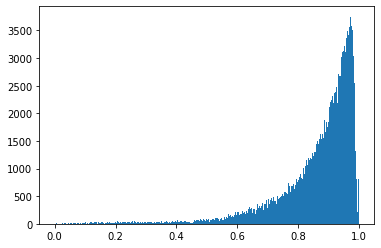

np_df 247009


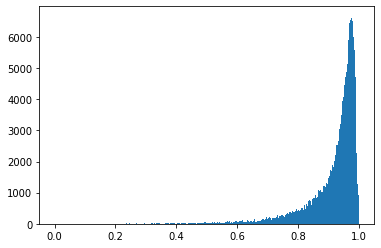

np_df 247009


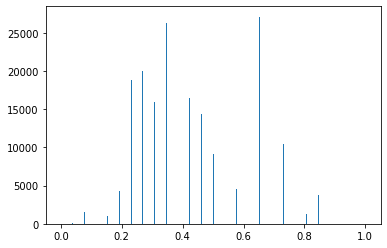

In [53]:
histgram(data_en_norm)
histgram(data_sound_norm)
histgram(data_graph_norm)#1から引いたもの

In [54]:
from scipy import  stats

def statistic(df):
    data = df.values
    print('平均値：', np.mean(data))
    print('中央値：', np.median(data))
    print('合計：', np.sum(data))
    print('分散',np.var(data,ddof=1))
    print('標準偏差',np.std(data,ddof=1))
    print('最大',np.max(data))
    print('最小',np.min(data))
    print('四分位点(25%)：', np.percentile(data, 25))
    print('四分位点(50%)：', np.percentile(data, 50))
    print('四分位点(75%)：', np.percentile(data, 75))
    print("")

In [55]:
statistic(data_en_norm)
statistic(data_sound_norm)
statistic(data_graph_norm)

平均値： 0.8622297210794415
中央値： 0.9048531011028096
合計： 212978.50117411176
分散 0.01807234402479116
標準偏差 0.13443341855651503
最大 1.0
最小 0.0
四分位点(25%)： 0.8193813981864121
四分位点(50%)： 0.9048531011028096
四分位点(75%)： 0.9528477765960692

平均値： 0.9164174466228006
中央値： 0.9490668747852387
合計： 226363.35707285133
分散 0.008474610586231623
標準偏差 0.09205764816804535
最大 1.0
最小 0.0
四分位点(25%)： 0.8967288514678636
四分位点(50%)： 0.9490668747852387
四分位点(75%)： 0.9721101798369577

平均値： 0.47457411237273517
中央値： 0.42307692307692313
合計： 117224.07692307694
分散 0.035830031066058136
標準偏差 0.1892882222063965
最大 1.0
最小 0.0
四分位点(25%)： 0.3076923076923077
四分位点(50%)： 0.42307692307692313
四分位点(75%)： 0.6538461538461539



In [56]:
#箱ひげ
def boxplot(df):
    data = df.to_numpy().ravel()
    plt.grid()
    plt.boxplot(data)
    plt.show()

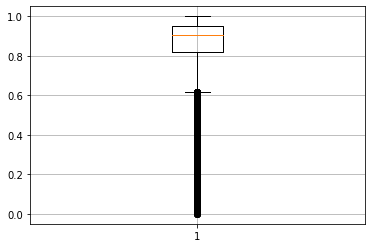

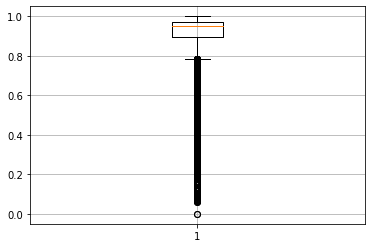

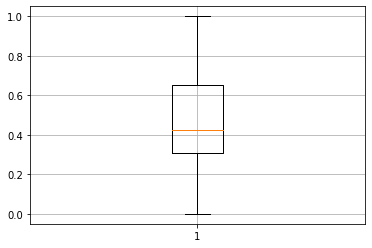

In [57]:
boxplot(data_en_norm)
boxplot(data_sound_norm)
boxplot(data_graph_norm)

In [28]:
#boxplot(data_en_norm)
#boxplot(data_sound_norm)
#boxplot(data_graph_norm)
data_en_norm_np=data_en_norm.to_numpy().ravel()
data_sound_norm_np=data_sound_norm.to_numpy().ravel()
data_graph_norm_np=data_graph_norm.to_numpy().ravel()

In [29]:
len(data_graph_norm)

247009

In [30]:
import pandas as pd
all_df=pd.DataFrame({"val":np.concatenate([data_en_norm_np,data_sound_norm_np,data_graph_norm_np]),"org":[0]*len(data_en_norm_np)+[1]*len(data_sound_norm_np)+[2]*len(data_graph_norm_np)},index=None)

In [31]:
all_df

val  org
0       1.000000    0
1       0.925158    0
2       0.737762    0
3       0.941445    0
4       0.673196    0
...          ...  ...
741022  0.653846    2
741023  0.653846    2
741024  0.653846    2
741025  0.653846    2
741026  1.000000    2

[741027 rows x 2 columns]

<AxesSubplot:xlabel='org', ylabel='val'>

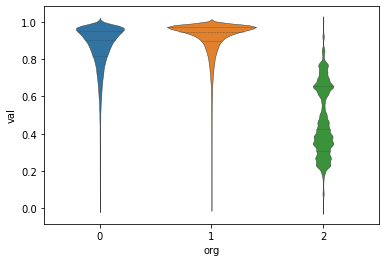

In [32]:
import seaborn as sns
sns.violinplot(data=all_df,x="org",y="val",inner="quartile",linewidth=0.5)

<AxesSubplot:xlabel='org', ylabel='val'>

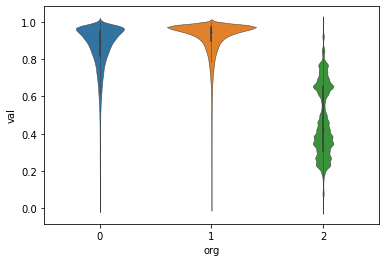

In [33]:
import seaborn as sns
sns.violinplot(data=all_df,x="org",y="val",inner="box",linewidth=0.5)

## 隣接グラフ

In [18]:
import pandas as pd
#data_jp = pd.read_csv('data_matrix/bert_jp.csv',index_col=0)
data_en = pd.read_csv('data_matrix/bert_en.csv',index_col=0)
data_sound = pd.read_csv('data_matrix/sound.csv',index_col=0)
data_graph = pd.read_csv('data_matrix/graph.csv',index_col=0)

In [2]:
def Norm(df):
    return (df - df.values.min()) / (df.values.max() - df.values.min())
#データの形を見てから決める　正規分布に近いかどうか

In [3]:
def Norm4graph(df):
    return (1-(df - df.values.min()) / (df.values.max() - df.values.min()))
#データの形を見てから決める　正規分布に近いかどうか

In [4]:
#data_jp_norm = Norm(data_jp)
data_en_norm = Norm(data_en)
data_sound_norm = Norm(data_sound)
data_graph_norm = Norm4graph(data_graph)

In [ ]:
#data_graph_normは1から引いておく
#閾値は中央値（まずはなるべくスパースな方が）

In [53]:
# def one_hot(df):
#     data = df.values
#     m = np.mean(data)
#     new_df=df.mask(df < m, 0).mask(df >= m, 1)
#     return new_df

In [5]:
# 行列を受け取り，閾値に基づいてエッジのリストを作成　ノードをIDで管理
def edge_lists(df,t):# Threshold
    edge_lists = []
    for i in df.index.values :
        for j in df.index.values :
            #描画したいものだけを抽出する
            if i != j:
                if (df.iloc[i,j] > t) & (df.iloc[i,j] != 1) :
                    tmp = (i,j,df.iloc[i,j]*10) #(from,to,weight)のタプルを作成
                    edge_lists.append(tmp)
    return edge_lists

In [6]:
# 行列を受け取り，閾値に基づいてエッジのリストを作成　ノードを表示名で管理
def edge_lists_name(df,t):
    edge_lists = []
    cols = df.columns
    for i in df.index.values :
        for j in df.index.values :
            #描画したいものだけを抽出する
            if i < j:
                if (df.iloc[i,j] > t) & (df.iloc[i,j] != 1) :
                    tmp = (cols[i],cols[j],df.iloc[i,j]*10) #(from,to,weight)のタプルを作成
                    edge_lists.append(tmp)
    return edge_lists

In [7]:
#エッジのリストからグラフDBを作成
import networkx as nx

def one_hot_Graph(edge_lists):
    # 描画の準備
    G = nx.Graph()
    G.add_weighted_edges_from(edge_lists)
#     plt.figure(figsize=(8,8))  #描画対象に合わせて設定する
#     np.random.seed(seed=1234)    #ノードポジションの再現性を確保するためseedを設定する
#     pos = nx.spring_layout(G)    #ノードのポジションの計算
#     nx.draw_networkx(G,pos=pos,font_size=15,alpha=0.8,font_family ='MS Gothic')
    return G

In [8]:
def cnt_com_edges(G1,G2):
    c = 0
    for edge in G1.edges():
        if G2.has_edge(*edge):
            c = c + 1
    return c

In [9]:
def cnt_com_edges_3(G1,G2,G3):
    c = 0
    for edge in G1.edges():
        if G2.has_edge(*edge):
            if G3.has_edge(*edge):
                c = c + 1
    return c

data_en_norm.values### 中央値による足切り

### 上位p%で足切りを繰り返すfor文

In [83]:
import numpy as np
import matplotlib.pyplot as plt

pre = []

en_G_list = []
sound_G_list = []
graph_G_list = []

en_nodes = []
sound_nodes = []
graph_nodes = []

num_en_edges = []
num_sound_edges = []
num_graph_edges = []

en_sound_edges = []
sound_graph_edges = []
en_graph_edges = []
en_sound_graph_edges = []


for p in range(50,100,2):
    print('\r%d / %d' %(p, 100), end='')
    pre.append(p)
    
    m1 = np.percentile(data_en_norm.values,p)
    m2 = np.percentile(data_sound_norm.values,p)
    m3 = np.percentile(data_graph_norm.values,p)

    en_edges = edge_lists(data_en_norm,m1)
    sound_edges = edge_lists(data_sound_norm,m2)
    graph_edges = edge_lists(data_graph_norm,m3)
    
    en_G = one_hot_Graph(en_edges)
    sound_G = one_hot_Graph(sound_edges)
    graph_G = one_hot_Graph(graph_edges)
    
    en_G_list.append(en_G)
    sound_G_list.append(sound_G)
    graph_G_list.append(graph_G)

    en_nodes.append(nx.number_of_nodes(en_G))
    sound_nodes.append(nx.number_of_nodes(sound_G))
    graph_nodes.append(nx.number_of_nodes(graph_G))

    num_en_edges.append(nx.number_of_edges(en_G))
    num_sound_edges.append(nx.number_of_edges(sound_G))
    num_graph_edges.append(nx.number_of_edges(graph_G))

    en_sound_edges.append(cnt_com_edges(en_G,sound_G))
    sound_graph_edges.append(cnt_com_edges(sound_G,graph_G))
    en_graph_edges.append(cnt_com_edges(en_G,graph_G))
    en_sound_graph_edges.append(cnt_com_edges_3(en_G,sound_G,graph_G))

98 / 100

In [79]:
num_en_edges = []
for i in en_edges:
    if isinstance(i, tuple):
        pass
    else:
        num_en_edges.append(i)

In [81]:
num_en_edges

[2185]

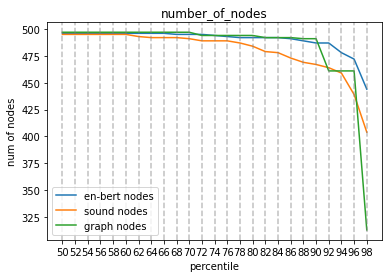

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(pre, en_nodes, label='en-bert nodes')
ax.plot(pre, sound_nodes, label='sound nodes')
ax.plot(pre, graph_nodes, label='graph nodes')


ax.set_xticks(pre[::1])
ax.set_xticklabels(pre[::1])
for xc in pre:
    plt.axvline(x=xc, linestyle='--', color='gray', alpha=0.5)

# グラフのタイトルや軸ラベルを設定
ax.set_title('number_of_nodes')
ax.set_xlabel('percentile')
ax.set_ylabel('num of nodes')

plt.legend()
# グラフを表示
plt.show()

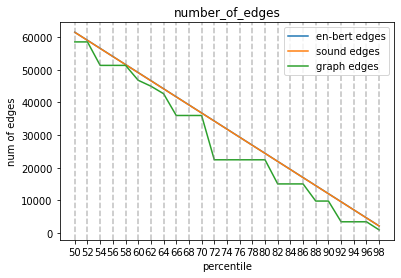

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(pre, num_en_edges, label='en-bert edges')
ax.plot(pre, num_sound_edges, label='sound edges')
ax.plot(pre, num_graph_edges, label='graph edges')


ax.set_xticks(pre[::1])
ax.set_xticklabels(pre[::1])
for xc in pre:
    plt.axvline(x=xc, linestyle='--', color='gray', alpha=0.5)

# グラフのタイトルや軸ラベルを設定
ax.set_title('number_of_edges')
ax.set_xlabel('percentile')
ax.set_ylabel('num of edges')

plt.legend()
# グラフを表示
plt.show()

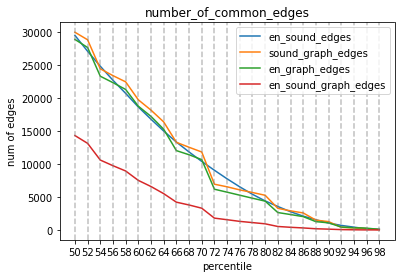

In [82]:
fig, ax = plt.subplots()
ax.plot(pre, en_sound_edges, label='en_sound_edges')
ax.plot(pre, sound_graph_edges, label='sound_graph_edges')
ax.plot(pre, en_graph_edges, label='en_graph_edges')
ax.plot(pre, en_sound_graph_edges, label='en_sound_graph_edges')


ax.set_xticks(pre[::1])
ax.set_xticklabels(pre[::1])
for xc in pre:
    plt.axvline(x=xc, linestyle='--', color='gray', alpha=0.5)

# グラフのタイトルや軸ラベルを設定
ax.set_title('number_of_common_edges')
ax.set_xlabel('percentile')
ax.set_ylabel('num of edges')

plt.legend()
# グラフを表示

In [92]:
# 23/3/27
# p=80の時，1万は他のグラフと共通，1万5千は自分だけのノード．
# 90～100までの間を拡大・より細かく分析
# 95で行ってみてグラフはどんな感じになるか　エッジの種類唖4種類＝＞他方一つとおなじ×２　自分だけ（グレー）　他方両方と同じ　の4種類

## 90～100までの間を拡大・より細かく分析

In [10]:
# 90～100までの間を拡大・より細かく分析
import numpy as np
import matplotlib.pyplot as plt

pre = []

en_G_list = []
sound_G_list = []
graph_G_list = []

en_nodes = []
sound_nodes = []
graph_nodes = []

num_en_edges = []
num_sound_edges = []
num_graph_edges = []

en_sound_edges = []
sound_graph_edges = []
en_graph_edges = []
en_sound_graph_edges = []


float_p = np.arange(90.0, 100.0, 0.1)
float_p = np.round(float_p, 1)
for p in float_p:
    print('\r%.1f / %d' %(p, 100), end='')
    pre.append(p)
    
    m1 = np.percentile(data_en_norm.values,p)
    m2 = np.percentile(data_sound_norm.values,p)
    m3 = np.percentile(data_graph_norm.values,p)

    en_edges = edge_lists(data_en_norm,m1)
    sound_edges = edge_lists(data_sound_norm,m2)
    graph_edges = edge_lists(data_graph_norm,m3)
    
    en_G = one_hot_Graph(en_edges)
    sound_G = one_hot_Graph(sound_edges)
    graph_G = one_hot_Graph(graph_edges)
    
    en_G_list.append(en_G)
    sound_G_list.append(sound_G)
    graph_G_list.append(graph_G)

    en_nodes.append(nx.number_of_nodes(en_G))
    sound_nodes.append(nx.number_of_nodes(sound_G))
    graph_nodes.append(nx.number_of_nodes(graph_G))

    num_en_edges.append(nx.number_of_edges(en_G))
    num_sound_edges.append(nx.number_of_edges(sound_G))
    num_graph_edges.append(nx.number_of_edges(graph_G))

    en_sound_edges.append(cnt_com_edges(en_G,sound_G))
    sound_graph_edges.append(cnt_com_edges(sound_G,graph_G))
    en_graph_edges.append(cnt_com_edges(en_G,graph_G))
    en_sound_graph_edges.append(cnt_com_edges_3(en_G,sound_G,graph_G))

99.9 / 100

In [12]:
import pickle

with open("data_90-100/pre.bin", 'wb') as f:
    pickle.dump(pre,f)
    
with open("data_90-100/en_G_list.bin", 'wb') as f:
    pickle.dump(en_G_list,f)
with open("data_90-100/sound_G_list.bin", 'wb') as f:
    pickle.dump(sound_G_list,f)
with open("data_90-100/graph_G_list.bin", 'wb') as f:
    pickle.dump(graph_G_list,f)

with open("data_90-100/en_nodes.bin", 'wb') as f:
    pickle.dump(en_nodes,f)
with open("data_90-100/sound_nodes.bin", 'wb') as f:
    pickle.dump(sound_nodes,f)
with open("data_90-100/graph_nodes.bin", 'wb') as f:
    pickle.dump(graph_nodes,f)
    
with open("data_90-100/num_en_edges.bin", 'wb') as f:
    pickle.dump(num_en_edges,f)
with open("data_90-100/num_sound_edges.bin", 'wb') as f:
    pickle.dump(num_sound_edges,f)
with open("data_90-100/num_graph_edges.bin", 'wb') as f:
    pickle.dump(num_graph_edges,f)
    
with open("data_90-100/en_sound_edges.bin", 'wb') as f:
    pickle.dump(en_sound_edges,f)
with open("data_90-100/sound_graph_edges.bin", 'wb') as f:
    pickle.dump(sound_graph_edges,f)
with open("data_90-100/en_graph_edges.bin", 'wb') as f:
    pickle.dump(en_graph_edges,f)
with open("data_90-100/en_sound_graph_edges.bin", 'wb') as f:
    pickle.dump(en_sound_graph_edges,f)

In [ ]:
import pickle

with open("data_90-100/pre.bin", 'wb') as f:
    pickle.dump(pre,f)
    pre = pickle.load(f)
    
with open("data_90-100/en_G_list.bin", 'wb') as f:
    pickle.dump(en_G_list,f)
with open("data_90-100/sound_G_list.bin", 'wb') as f:
    pickle.dump(sound_G_list,f)
with open("data_90-100/graph_G_list.bin", 'wb') as f:
    pickle.dump(graph_G_list,f)

with open("data_90-100/en_nodes.bin", 'wb') as f:
    pickle.dump(en_nodes,f)
with open("data_90-100/sound_nodes.bin", 'wb') as f:
    pickle.dump(sound_nodes,f)
with open("data_90-100/graph_nodes.bin", 'wb') as f:
    pickle.dump(graph_nodes,f)
    
with open("data_90-100/num_en_edges.bin", 'wb') as f:
    pickle.dump(num_en_edges,f)
with open("data_90-100/num_sound_edges.bin", 'wb') as f:
    pickle.dump(num_sound_edges,f)
with open("data_90-100/num_graph_edges.bin", 'wb') as f:
    pickle.dump(num_graph_edges,f)
    
with open("data_90-100/en_sound_edges.bin", 'wb') as f:
    pickle.dump(en_sound_edges,f)
with open("data_90-100/sound_graph_edges.bin", 'wb') as f:
    pickle.dump(sound_graph_edges,f)
with open("data_90-100/en_graph_edges.bin", 'wb') as f:
    pickle.dump(en_graph_edges,f)
with open("data_90-100/en_sound_graph_edges.bin", 'wb') as f:
    pickle.dump(en_sound_graph_edges,f)

In [4]:
import pickle

# with open("data_90-100/pre.bin", 'rb') as f:
#     pre= pickle.load(f)
    
with open("data_90-100/en_G_list.bin", 'rb') as f:
    en_G_list= pickle.load(f)
with open("data_90-100/sound_G_list.bin", 'rb') as f:
    sound_G_list= pickle.load(f)
with open("data_90-100/graph_G_list.bin", 'rb') as f:
    graph_G_list= pickle.load(f)

with open("data_90-100/en_nodes.bin", 'rb') as f:
    en_nodes= pickle.load(f)
with open("data_90-100/sound_nodes.bin", 'rb') as f:
    sound_nodes= pickle.load(f)
with open("data_90-100/graph_nodes.bin", 'rb') as f:
    graph_nodes= pickle.load(f)
    
with open("data_90-100/num_en_edges.bin", 'rb') as f:
    num_en_edges= pickle.load(f)
with open("data_90-100/num_sound_edges.bin", 'rb') as f:
    num_sound_edges= pickle.load(f)
with open("data_90-100/num_graph_edges.bin", 'rb') as f:
    num_graph_edges= pickle.load(f)
    
with open("data_90-100/en_sound_edges.bin", 'rb') as f:
    en_sound_edges= pickle.load(f)
with open("data_90-100/sound_graph_edges.bin", 'rb') as f:
    sound_graph_edges= pickle.load(f)
with open("data_90-100/en_graph_edges.bin", 'rb') as f:
    en_graph_edges= pickle.load(f)
with open("data_90-100/en_sound_graph_edges.bin", 'rb') as f:
    en_sound_graph_edges= pickle.load(f)

In [8]:
import numpy as np
pre = []
float_p = np.arange(90.0, 100.0, 0.1)
float_p = np.round(float_p, 1)
for p in float_p:
    pre.append(p)

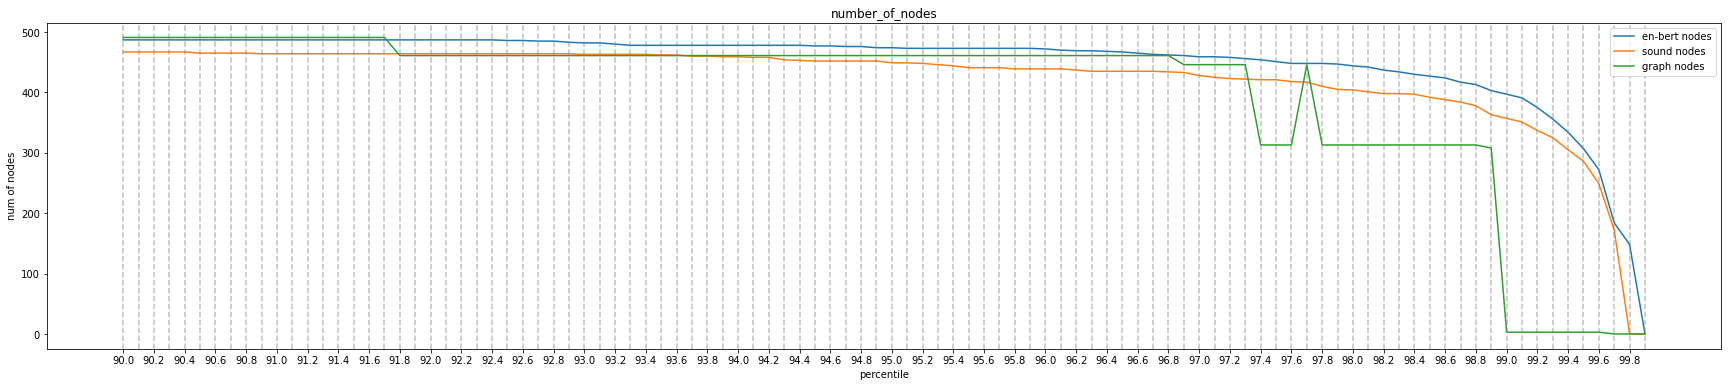

In [24]:
import matplotlib.pyplot as plt

plt
fig, ax = plt.subplots(figsize=(30.0,6.0))
ax.plot(pre, en_nodes, label='en-bert nodes')
ax.plot(pre, sound_nodes, label='sound nodes')
ax.plot(pre, graph_nodes, label='graph nodes')

ax.set_xticks(pre[::2])
ax.set_xticklabels(pre[::2])
for xc in pre:
    plt.axvline(x=xc, linestyle='--', color='gray', alpha=0.5)

# グラフのタイトルや軸ラベルを設定
ax.set_title('number_of_nodes')
ax.set_xlabel('percentile')
ax.set_ylabel('num of nodes')

plt.legend()
# グラフを表示
plt.show()

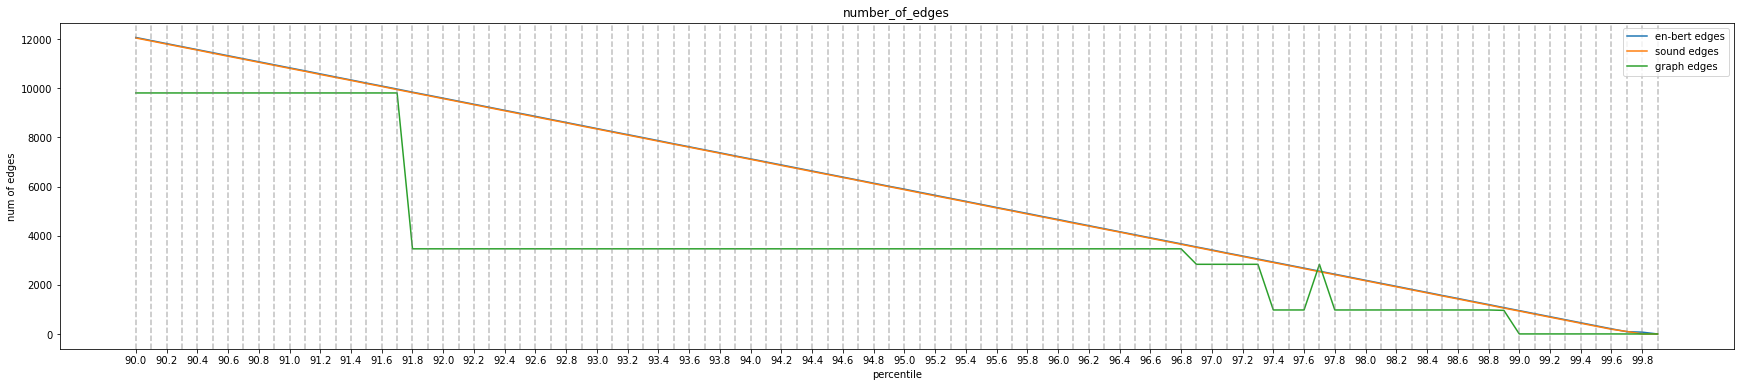

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30.0,6.0))
ax.plot(pre, num_en_edges, label='en-bert edges')
ax.plot(pre, num_sound_edges, label='sound edges')
ax.plot(pre, num_graph_edges, label='graph edges')


ax.set_xticks(pre[::2])
ax.set_xticklabels(pre[::2])
for xc in pre:
    plt.axvline(x=xc, linestyle='--', color='gray', alpha=0.5)

# グラフのタイトルや軸ラベルを設定
ax.set_title('number_of_edges')
ax.set_xlabel('percentile')
ax.set_ylabel('num of edges')

plt.legend()
# グラフを表示
plt.show()

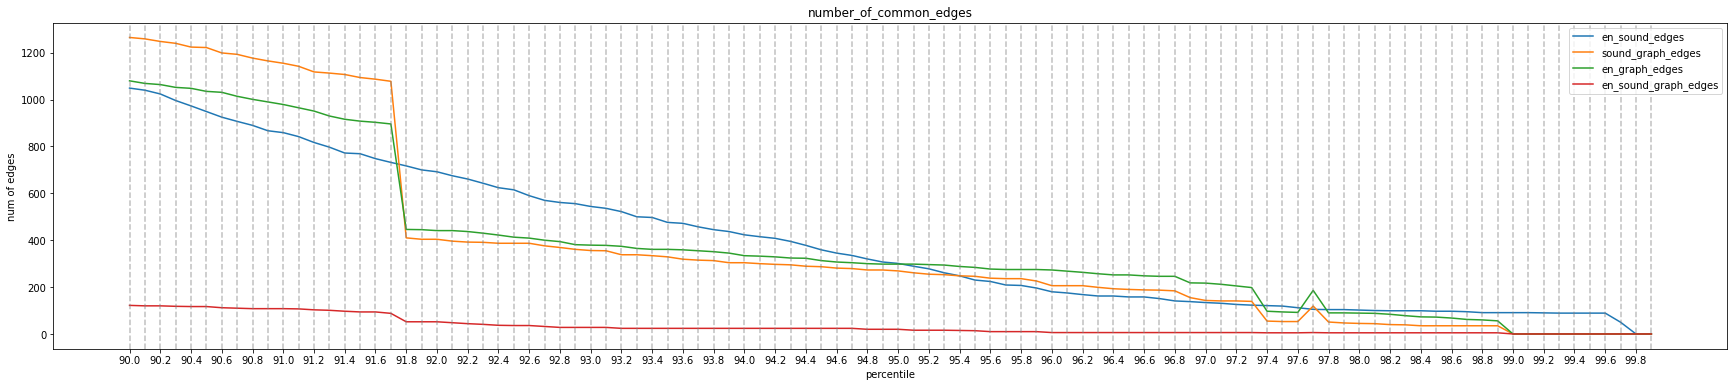

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30.0,6.0))
ax.plot(pre, en_sound_edges, label='en_sound_edges')
ax.plot(pre, sound_graph_edges, label='sound_graph_edges')
ax.plot(pre, en_graph_edges, label='en_graph_edges')
ax.plot(pre, en_sound_graph_edges, label='en_sound_graph_edges')

ax.set_xticks(pre[::2])
ax.set_xticklabels(pre[::2])
for xc in pre:
    plt.axvline(x=xc, linestyle='--', color='gray', alpha=0.5)

# グラフのタイトルや軸ラベルを設定
ax.set_title('number_of_common_edges')
ax.set_xlabel('percentile')
ax.set_ylabel('num of edges')

plt.legend()
# グラフを表示

In [51]:
en_G_list[50]

In [46]:
i = 50 #95.0
G = nx.compose(en_G_list[i],sound_G_list[i])
G = nx.compose(G,graph_G_list[i])

In [40]:
edge_list = list(G.edges())

In [100]:
bird_name = [j for j in data_graph.columns.values]
node_labels = {}
for t in range(len(bird_name)):
    if t in G.nodes():
        node_labels[t] = bird_name[t].split("/")[1]

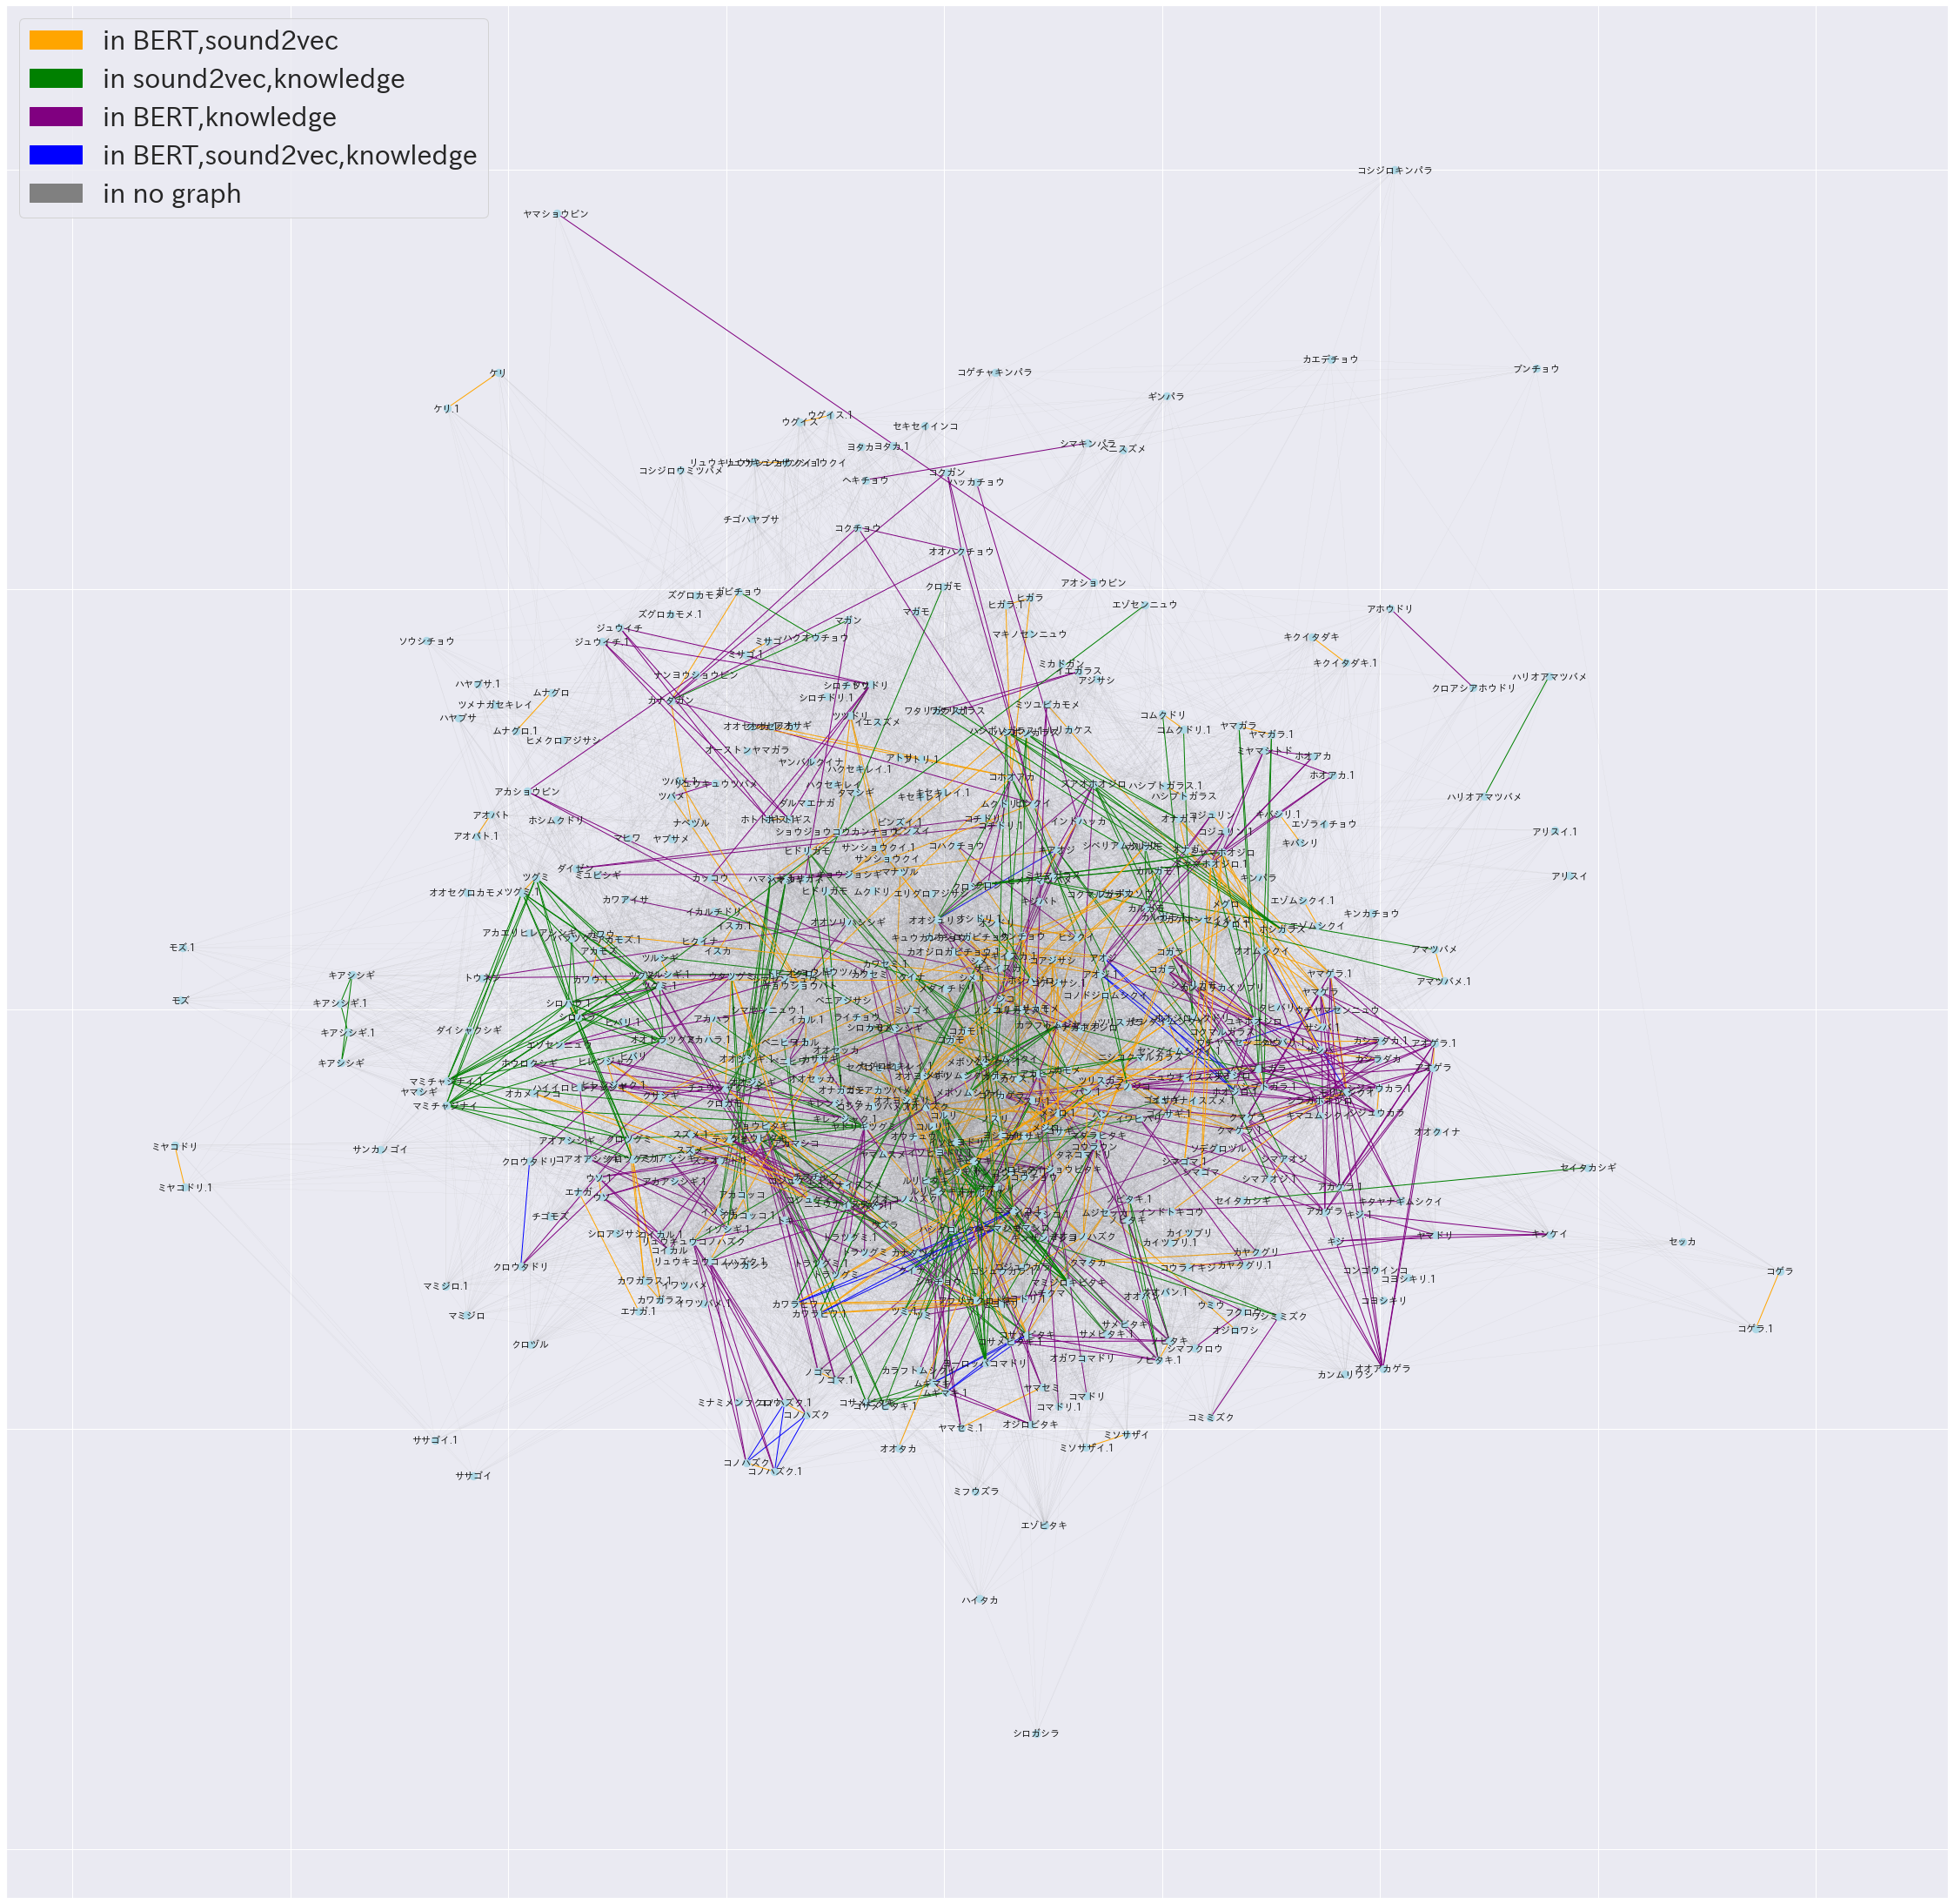

In [99]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set(font="IPAexGothic")
import japanize_matplotlib

# グラフのレイアウトを設定
pos = nx.spring_layout(G, k=0.5, seed=42)

# ノードのサイズと色、ラベルのフォントサイズを設定
node_size = 70
node_color = 'lightblue'
font_size = 11

# エッジの色を設定
edge_colors = []
for u, v in G.edges():
    if en_G_list[i].has_edge(u, v) and sound_G_list[i].has_edge(u, v) and graph_G_list[i].has_edge(u, v):
        edge_colors.append('blue')
    elif en_G_list[i].has_edge(u, v) and sound_G_list[i].has_edge(u, v):
        edge_colors.append('orange')
    elif sound_G_list[i].has_edge(u, v) and graph_G_list[i].has_edge(u, v):
        edge_colors.append('green')
    elif graph_G_list[i].has_edge(u, v) and en_G_list[i].has_edge(u, v):
        edge_colors.append('purple')#色付きは太め＋色を濃く
    else:
        edge_colors.append((0.5, 0.5, 0.5, 0.5))#グレー半透明
# グラフを描画
plt.figure(figsize=(40, 40))
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors, width=[1.0 if c in ["blue","orange","green","purple"] else 0.09 for c in edge_colors])
nx.draw_networkx_labels(G, pos, labels=node_labels,font_size=font_size, font_weight='bold',font_family='IPAexGothic')
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# plt.axis()

# 凡例をグラフに追加
p1 = mpatches.Patch(color='orange', label='in BERT,sound2vec')
p2 = mpatches.Patch(color='green', label='in sound2vec,knowledge')
p3 = mpatches.Patch(color='purple', label='in BERT,knowledge')
p4 = mpatches.Patch(color='blue', label='in BERT,sound2vec,knowledge')
p5 = mpatches.Patch(color='gray', label='in no graph')
plt.legend(handles=[p1,p2,p3,p4,p5], fontsize=30, loc='upper left')

plt.show()

In [ ]:
#  'Q1272062 :Heteroscelus brevipes/キアシシギ',
#  'Q11848755 :Grey-tailed Tattler/キアシシギ',
#  'Q1272062 :Heteroscelus brevipes/キアシシギ.1',
#  'Q11848755 :Grey-tailed Tattler/キアシシギ.1',

#類似度が１となった自分自身をはじいてしまっている？

In [ ]:
# 23/4/10
#　グラフで大きく下がる前か後か？　どちらの可能性もあり
#　グラフ95　残り98の閾値
# ノードは載せないか　鳥の名前
# 各色の説明
# 図を試行錯誤する

In [ ]:
# 閾値に関しては95が最も良い

In [ ]:
# 23/4/28
# キアシシギの確認
# API化

In [15]:
import networkx as nx
i = 80 #98.0
G = nx.compose(en_G_list[i],sound_G_list[i])
G = nx.compose(G,graph_G_list[i])

In [16]:
edge_list = list(G.edges())

In [19]:
data_graph = pd.read_csv('data_matrix/graph.csv',index_col=0)

In [20]:
bird_name = [j for j in data_graph.columns.values]
node_labels = {}
for t in range(len(bird_name)):
    if t in G.nodes():
        node_labels[t] = bird_name[t].split("/")[1]

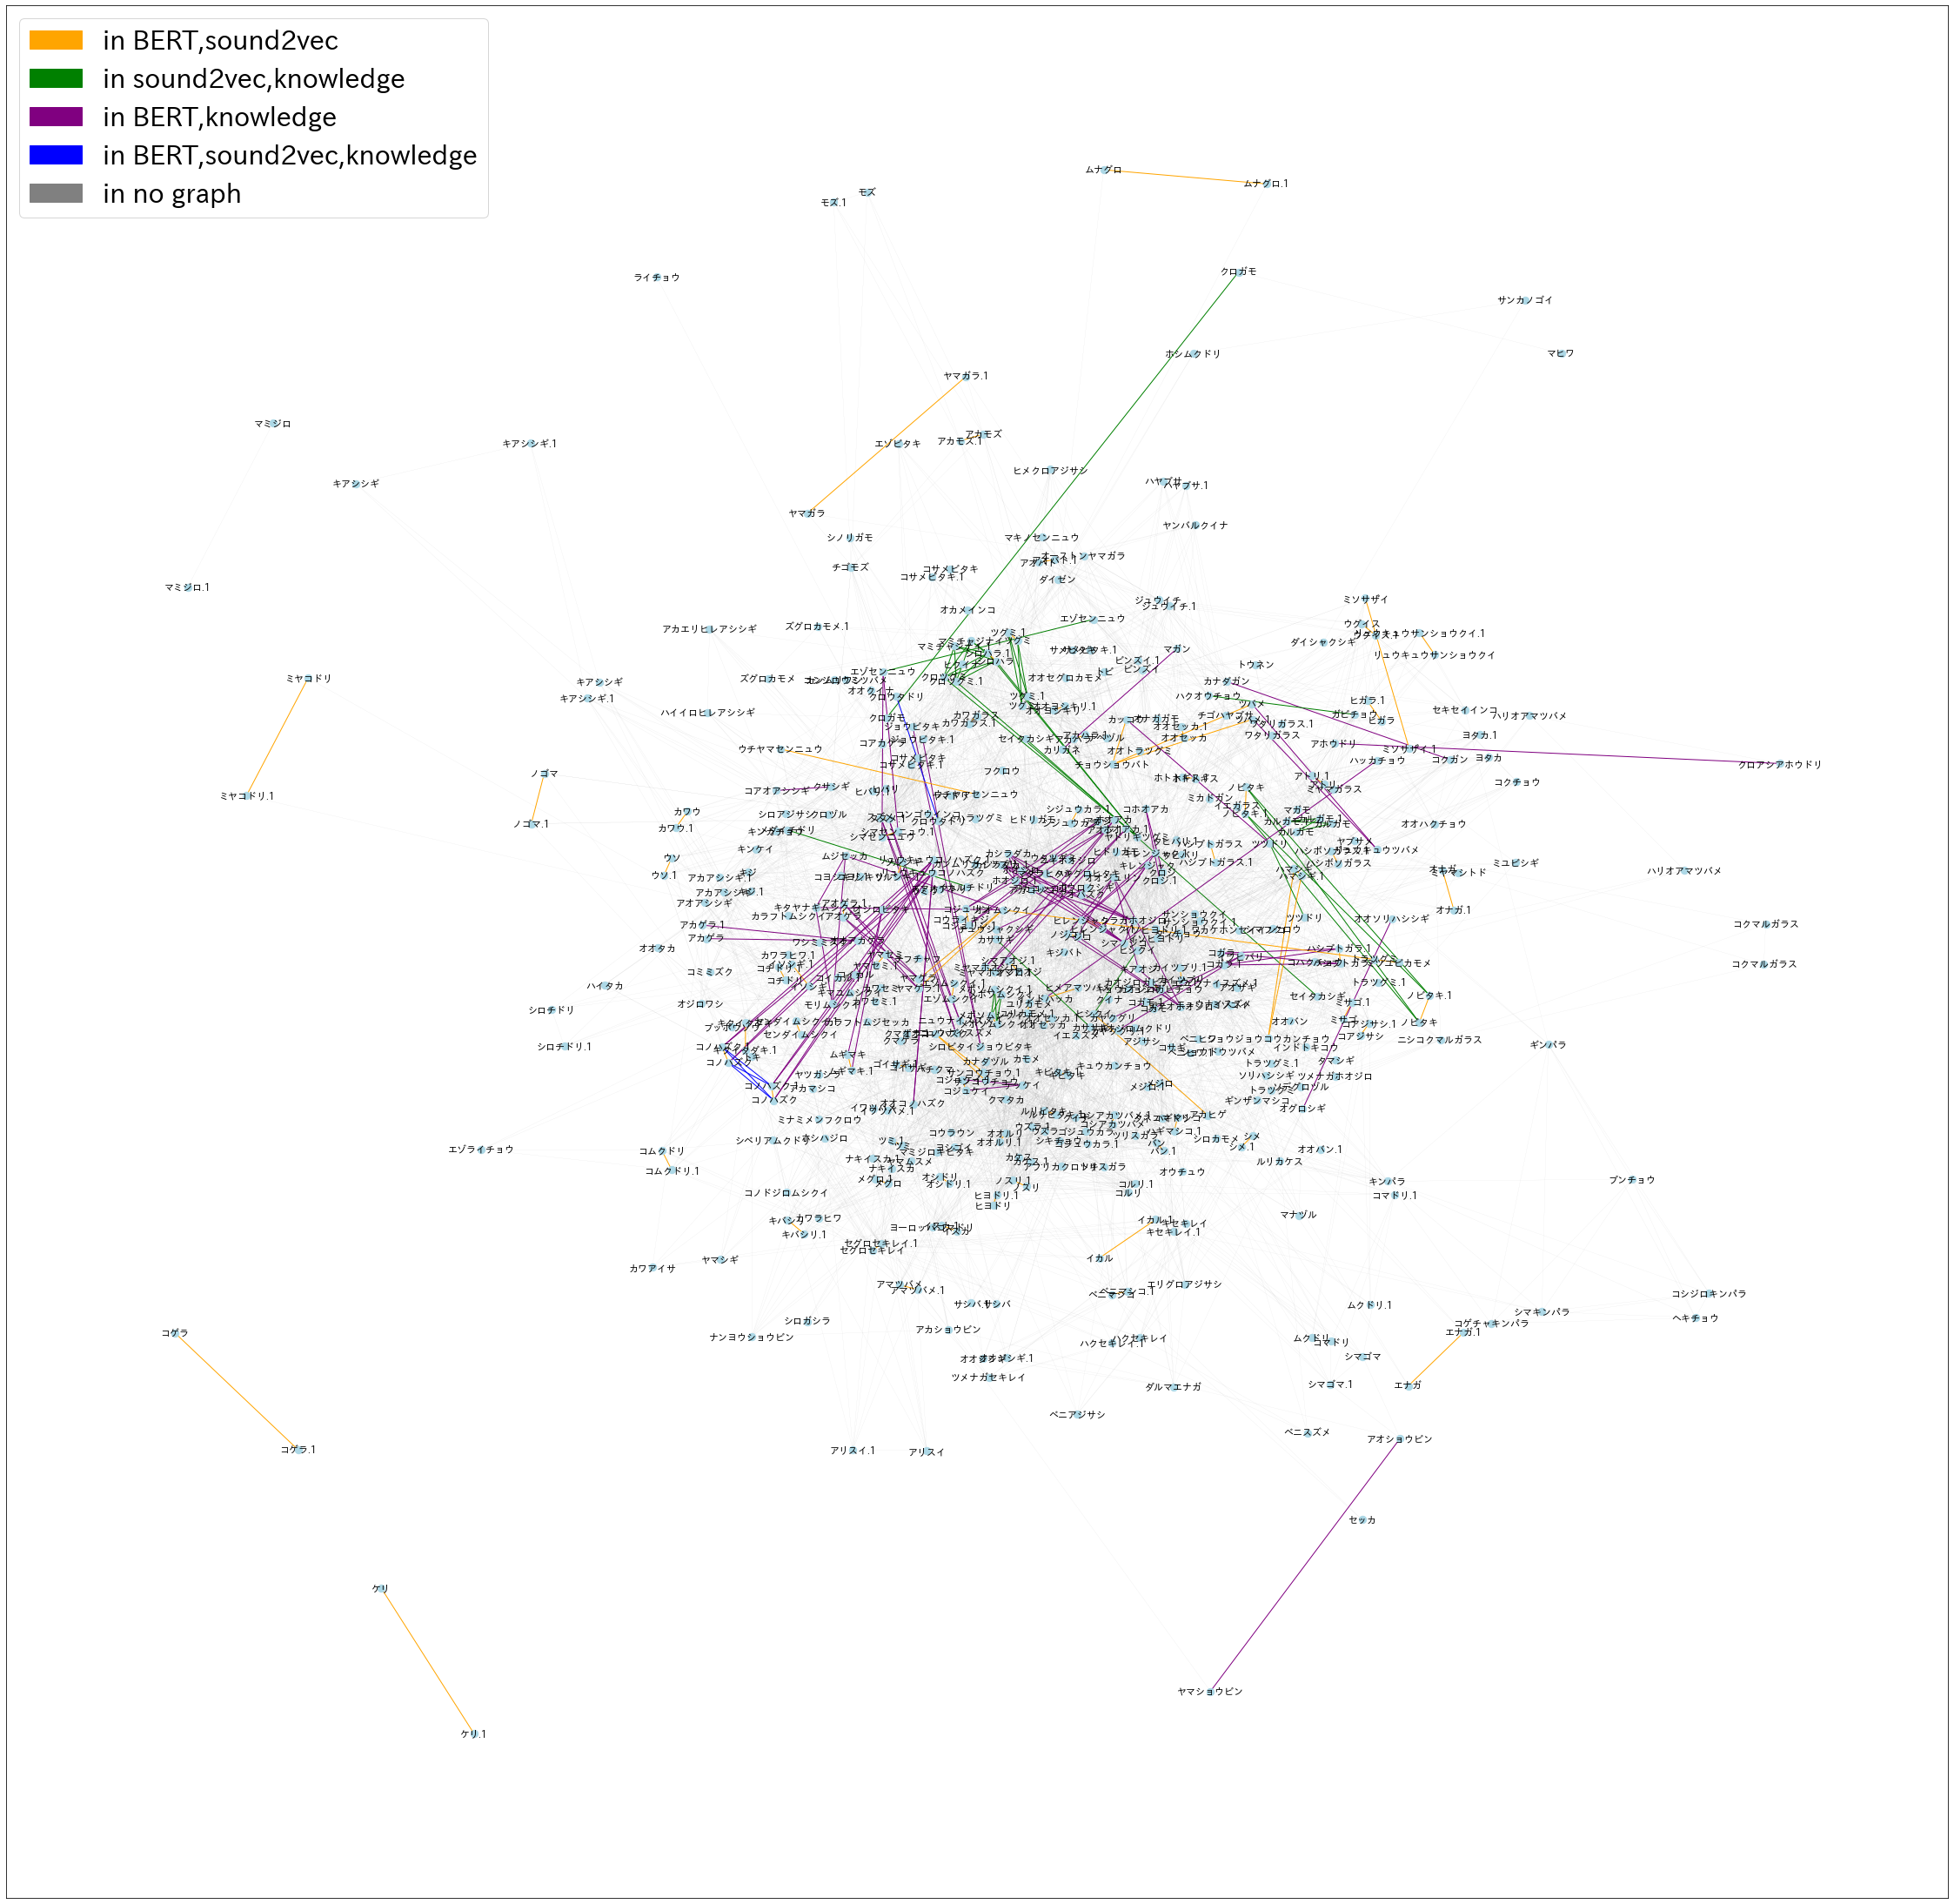

In [22]:

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# sns.set(font="IPAexGothic")
import japanize_matplotlib

# グラフのレイアウトを設定
pos = nx.spring_layout(G, k=0.5, seed=42)

# ノードのサイズと色、ラベルのフォントサイズを設定
node_size = 70
node_color = 'lightblue'
font_size = 11

# エッジの色を設定
edge_colors = []
for u, v in G.edges():
    if en_G_list[i].has_edge(u, v) and sound_G_list[i].has_edge(u, v) and graph_G_list[i].has_edge(u, v):
        edge_colors.append('blue')
    elif en_G_list[i].has_edge(u, v) and sound_G_list[i].has_edge(u, v):
        edge_colors.append('orange')
    elif sound_G_list[i].has_edge(u, v) and graph_G_list[i].has_edge(u, v):
        edge_colors.append('green')
    elif graph_G_list[i].has_edge(u, v) and en_G_list[i].has_edge(u, v):
        edge_colors.append('purple')#色付きは太め＋色を濃く
    else:
        edge_colors.append((0.5, 0.5, 0.5, 0.5))#グレー半透明
# グラフを描画
plt.figure(figsize=(40, 40))
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors, width=[1.0 if c in ["blue","orange","green","purple"] else 0.09 for c in edge_colors])
nx.draw_networkx_labels(G, pos, labels=node_labels,font_size=font_size, font_weight='bold',font_family='IPAexGothic')
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# plt.axis()

# 凡例をグラフに追加
p1 = mpatches.Patch(color='orange', label='in BERT,sound2vec')
p2 = mpatches.Patch(color='green', label='in sound2vec,knowledge')
p3 = mpatches.Patch(color='purple', label='in BERT,knowledge')
p4 = mpatches.Patch(color='blue', label='in BERT,sound2vec,knowledge')
p5 = mpatches.Patch(color='gray', label='in no graph')
plt.legend(handles=[p1,p2,p3,p4,p5], fontsize=30, loc='upper left')

plt.show()

### うまく軽量化できたものをpyvisグラフにより確認

In [73]:
#pyvisグラフにより確認
from pyvis.network import Network

g = Network()
g.from_nx(en_name_G)
for i, edge in enumerate(g.edges):
    if abs(edge['weight']) > 0.1:
        g.edges[i]['width'] = abs(edge['weight']) * 10.0
    else:
        g.edges[i]['width'] = 0.0
g.show_buttons(filter_=['physics', 'nodes'])
g.show("en_name_G.html")

In [74]:
g = Network()
g.from_nx(sound_name_G)
for i, edge in enumerate(g.edges):
    if abs(edge['weight']) > 0.1:
        g.edges[i]['width'] = abs(edge['weight']) * 10.0
    else:
        g.edges[i]['width'] = 0.0
g.show_buttons(filter_=['physics', 'nodes'])
g.show("sound_name_G.html")

In [23]:
g = Network()
g.from_nx(graph_name_G)
for i, edge in enumerate(g.edges):
    if abs(edge['weight']) > 0.1:
        g.edges[i]['width'] = abs(edge['weight']) * 10.0
    else:
        g.edges[i]['width'] = 0.0
g.show_buttons(filter_=['physics', 'nodes'])
g.show("graph_name_G.html")

In [ ]:
# 75,80,90,99 やりすぎると途切れる

In [ ]:
#ベン図を書く

In [ ]:
# 原稿

In [120]:
# ロボット学会＝＞デモ等，API等で動かしたい　APIフレームワーク

In [ ]:
# Flaskとか？勉強しておく

In [ ]:
#ロボット学会
#6/14 申込
#7/14 論文締切

# https://ac.rsj-web.org/2023/
# 第41回 日本ロボット学会学術講演会

In [ ]:
# 関数ネットワークXなので輪生ｎは余裕で取ってこれる
# コアは音

# バイナリなので


# その結果を上位の種はこれ　下位の種はこれで　とGPTが自然言語で返答
# chatGPT
#ＬａｎｇＣｈａｉｎ経由で使用


# 音声を埋め込む
# 音声に関しては類似度

# クエリは検索モジュールにかける　新規のテキストからどれが近いか
# 近いものから　グラフモジュールで完全に引っ張ってくる
# （これはグラフを作成したときの類似度は削除）

# Wikiデータだけ有向グラフ

In [ ]:
# 隣接一つまずはとってくる

# ChatGPTが理解できるよう，余計な情報は名来る（一旦は全部乗っける）